In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [2]:
base_path = 'dataset_nyc_taxi_samples/parquet/'

## Green taxi

In [3]:
train_df = pd.read_parquet(base_path + 'green_train_1M.parquet')
train_df.head()

VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
0         2  2019-02-13 17:01:41   2019-02-13 17:37:01                  N   
1         2  2019-02-07 13:27:28   2019-02-07 14:18:20                  N   
2         2  2019-02-21 16:18:52   2019-02-21 16:24:24                  N   
3         2  2019-02-13 12:15:54   2019-02-13 12:49:14                  N   
4         2  2019-02-09 16:09:02   2019-02-09 16:18:32                  N   

   RatecodeID  PULocationID  DOLocationID  passenger_count  trip_distance  \
0         1.0           168           183              1.0           6.74   
1         5.0            85            42              1.0          17.61   
2         1.0           212           250              1.0           0.88   
3         1.0           244           238              1.0           4.59   
4         1.0           226             7              1.0           1.36   

   fare_amount  ...  dew_point_2m (°C)  apparent_temperature (°C)  \
0        27.00  ...               -8.9                       -4.9   
1        51.58  ...                3.8                        3.4   
2         6.00  ...                0.1                        6.6   
3        21.50  ...               -6.1                       -2.2   
4         8.00  ...              -14.0                       -6.9   

   precipitation (mm)  rain (mm)  snowfall (cm)  snow_depth (m)  \
0                 0.0        0.0            0.0            0.02   
1                 0.0        0.0            0.0            0.00   
2                 0.0        0.0            0.0            0.03   
3                 0.0        0.0            0.0            0.03   
4                 0.0        0.0            0.0            0.00   

   surface_pressure (hPa)  cloud_cover (%)  wind_speed_10m (km/h)  is_day ()  
0                  1000.1              100                   34.0          1  
1                  1013.1              100                   11.2          1  
2                  1007.2                4                   17.8          1  
3                   998.9               88                   33.1          1  
4                  1029.7                0                   26.5          1  

[5 rows x 33 columns]

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999970 entries, 0 to 999969
Data columns (total 33 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   VendorID                   999970 non-null  int64         
 1   lpep_pickup_datetime       999970 non-null  datetime64[ns]
 2   lpep_dropoff_datetime      999970 non-null  datetime64[ns]
 3   store_and_fwd_flag         999970 non-null  object        
 4   RatecodeID                 999970 non-null  float64       
 5   PULocationID               999970 non-null  int64         
 6   DOLocationID               999970 non-null  int64         
 7   passenger_count            999970 non-null  float64       
 8   trip_distance              999970 non-null  float64       
 9   fare_amount                999970 non-null  float64       
 10  extra                      999970 non-null  float64       
 11  mta_tax                    999970 non-null  float64 

In [5]:
train_df['store_and_fwd_flag'].unique()

array(['N', 'Y'], dtype=object)

In [6]:
train_df['store_and_fwd_flag'] = train_df['store_and_fwd_flag'] == 'Y'
train_df['store_and_fwd_flag'] = train_df['store_and_fwd_flag'].astype(int)

In [7]:
# add new time-connected columns
train_df['trip_time'] = train_df['lpep_dropoff_datetime'] - train_df['lpep_pickup_datetime']
train_df['trip_time'] = train_df['trip_time'].values.astype(float)//10**9

train_df['year'] = train_df['lpep_pickup_datetime'].dt.year
train_df['month'] = train_df['lpep_pickup_datetime'].dt.month
train_df['weekday'] = train_df['lpep_pickup_datetime'].dt.weekday
train_df['hour'] = train_df['lpep_pickup_datetime'].dt.hour

train_df = train_df.drop(columns=['lpep_pickup_datetime', 'lpep_dropoff_datetime', 'ehail_fee'])

In [8]:
train_df.head()

VendorID  store_and_fwd_flag  RatecodeID  PULocationID  DOLocationID  \
0         2                   0         1.0           168           183   
1         2                   0         5.0            85            42   
2         2                   0         1.0           212           250   
3         2                   0         1.0           244           238   
4         2                   0         1.0           226             7   

   passenger_count  trip_distance  fare_amount  extra  mta_tax  ...  \
0              1.0           6.74        27.00    1.0      0.5  ...   
1              1.0          17.61        51.58    0.0      0.5  ...   
2              1.0           0.88         6.00    1.0      0.5  ...   
3              1.0           4.59        21.50    0.0      0.5  ...   
4              1.0           1.36         8.00    0.0      0.5  ...   

   snow_depth (m)  surface_pressure (hPa)  cloud_cover (%)  \
0            0.02                  1000.1              100   
1            0.00                  1013.1              100   
2            0.03                  1007.2                4   
3            0.03                   998.9               88   
4            0.00                  1029.7                0   

   wind_speed_10m (km/h)  is_day ()  trip_time  year  month  weekday  hour  
0                   34.0          1     2120.0  2019      2        2    17  
1                   11.2          1     3052.0  2019      2        3    13  
2                   17.8          1      332.0  2019      2        3    16  
3                   33.1          1     2000.0  2019      2        2    12  
4                   26.5          1      570.0  2019      2        5    16  

[5 rows x 35 columns]

In [9]:
train_df = train_df.dropna()

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999704 entries, 0 to 999969
Data columns (total 35 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   VendorID                   999704 non-null  int64  
 1   store_and_fwd_flag         999704 non-null  int32  
 2   RatecodeID                 999704 non-null  float64
 3   PULocationID               999704 non-null  int64  
 4   DOLocationID               999704 non-null  int64  
 5   passenger_count            999704 non-null  float64
 6   trip_distance              999704 non-null  float64
 7   fare_amount                999704 non-null  float64
 8   extra                      999704 non-null  float64
 9   mta_tax                    999704 non-null  float64
 10  tip_amount                 999704 non-null  float64
 11  tolls_amount               999704 non-null  float64
 12  improvement_surcharge      999704 non-null  float64
 13  total_amount               99

<Axes: >

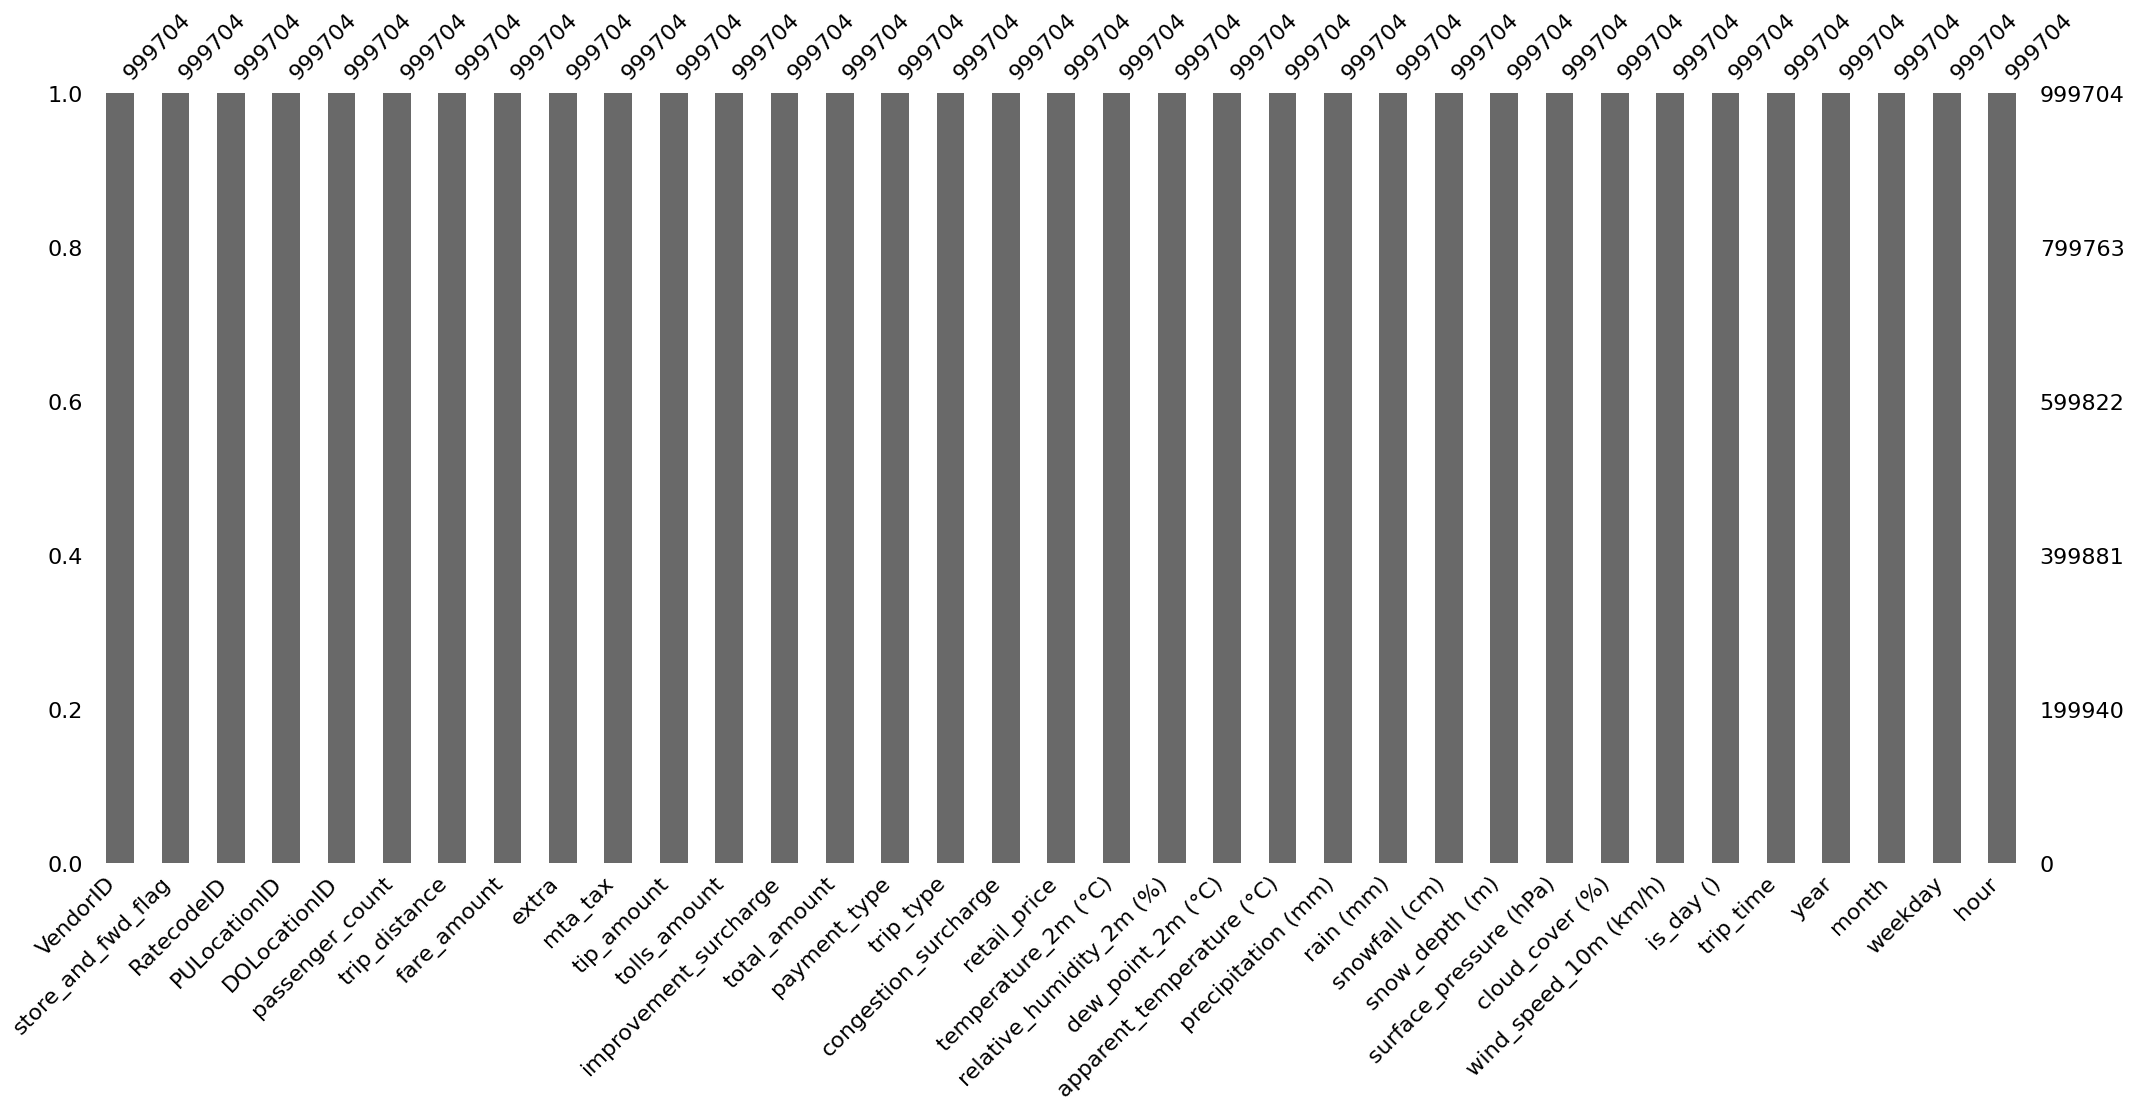

In [11]:
import missingno as msno

msno.bar(train_df)

In [12]:
kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto").fit(train_df)

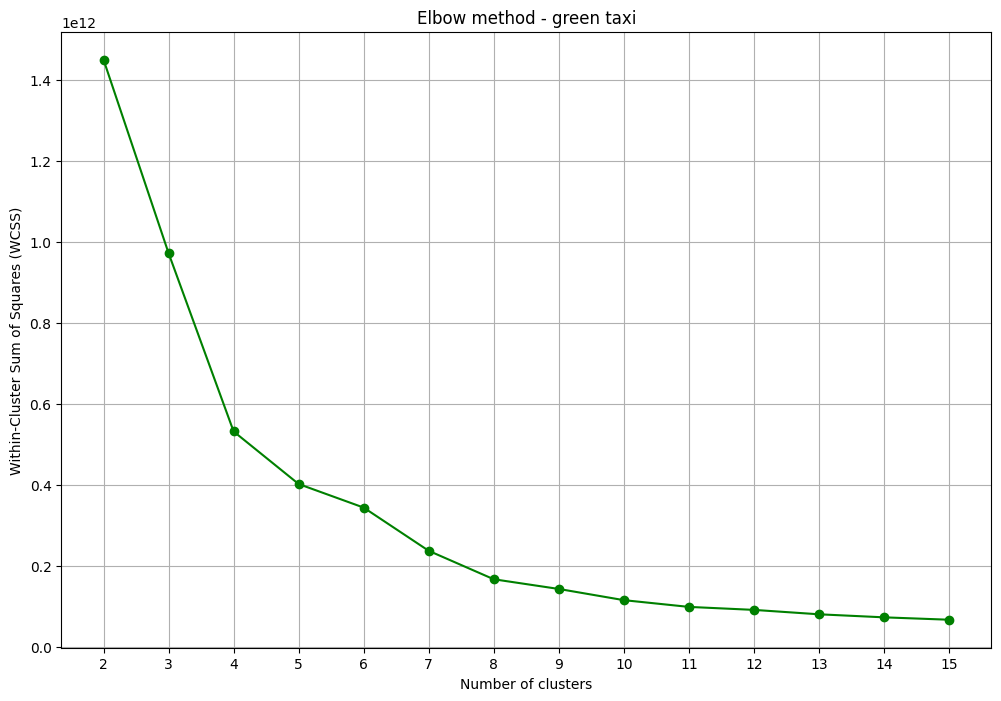

In [20]:
max_clusters = 16

wcss = []
for i in range(2, max_clusters):
    kmeans = KMeans(n_clusters=i, n_init="auto", random_state=42).fit(train_df)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(12, 8))
plt.plot(range(2, max_clusters), wcss, marker='o', linestyle='-', color='green')
plt.title('Elbow method - green taxi')
plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(range(2, max_clusters))
plt.grid(True)
plt.show()

In [12]:
n_samples = 10 ** 4

smaller_train_df = train_df.sample(n_samples)

2 clusters
3 clusters
4 clusters
5 clusters
6 clusters
7 clusters
8 clusters
9 clusters
10 clusters
11 clusters
12 clusters
13 clusters
14 clusters
15 clusters


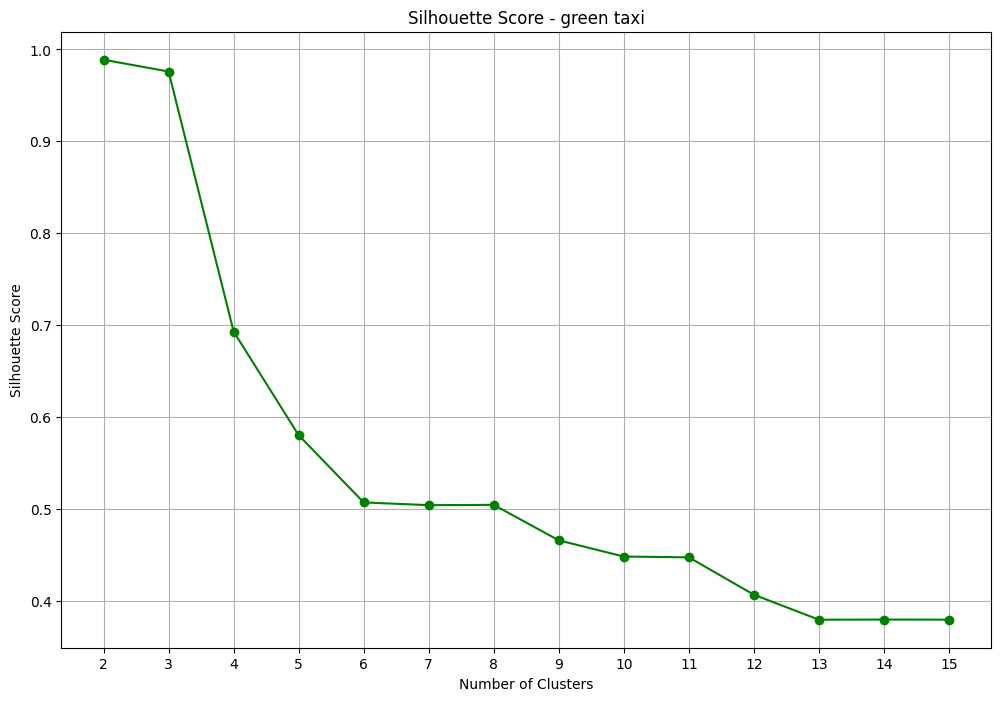

In [27]:
silhouette_scores = []

for i in range(2, max_clusters):
    kmeans = KMeans(n_clusters=i, n_init="auto", random_state=42)
    cluster_labels = kmeans.fit_predict(smaller_train_df)
    silhouette_avg = silhouette_score(smaller_train_df, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(12, 8))
plt.plot(range(2, max_clusters), silhouette_scores, marker='o', linestyle='-', color='green')
plt.title('Silhouette Score - green taxi')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, max_clusters))
plt.grid(True)
plt.show()

In [16]:
n_samples = 5000

plot_train_df = train_df.sample(n_samples, random_state=42)

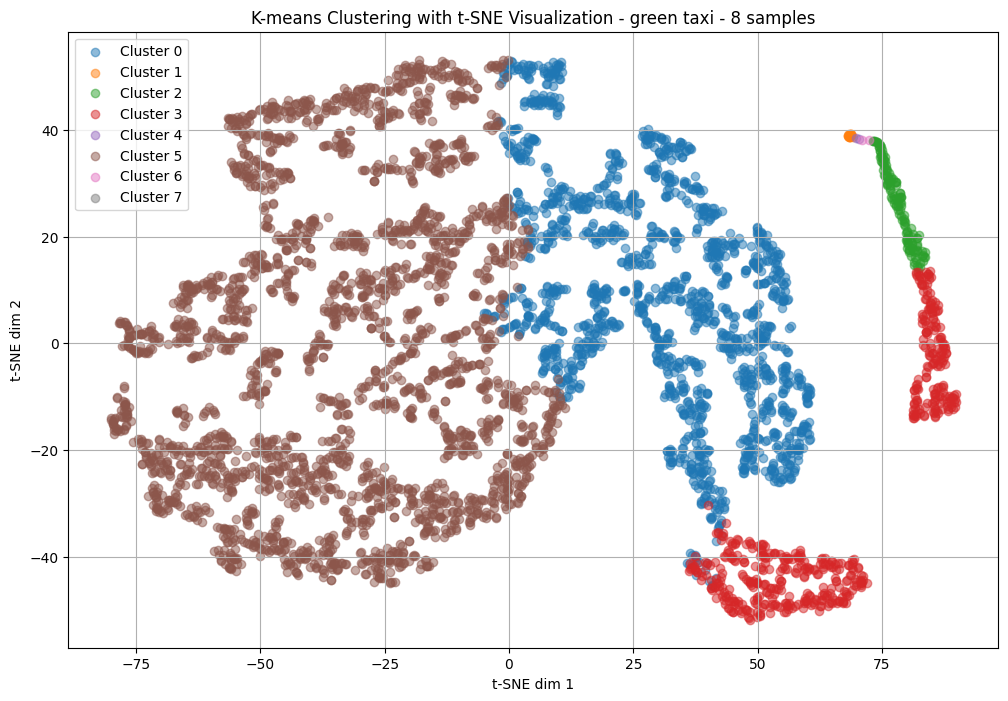

In [22]:
clusters_num = 8

kmeans = KMeans(n_clusters=clusters_num, n_init="auto", random_state=42).fit(train_df)
cluster_labels = kmeans.predict(plot_train_df)

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(plot_train_df)

plt.figure(figsize=(12, 8))
for i in range(clusters_num):
    plt.scatter(X_tsne[cluster_labels == i, 0], X_tsne[cluster_labels == i, 1], label=f'Cluster {i}',  alpha=0.5)
    
plt.title(f'K-means Clustering with t-SNE Visualization - green taxi - {clusters_num} clusters')
plt.xlabel('t-SNE dim 1')
plt.ylabel('t-SNE dim 2')
plt.legend()
plt.grid(True)
plt.show()

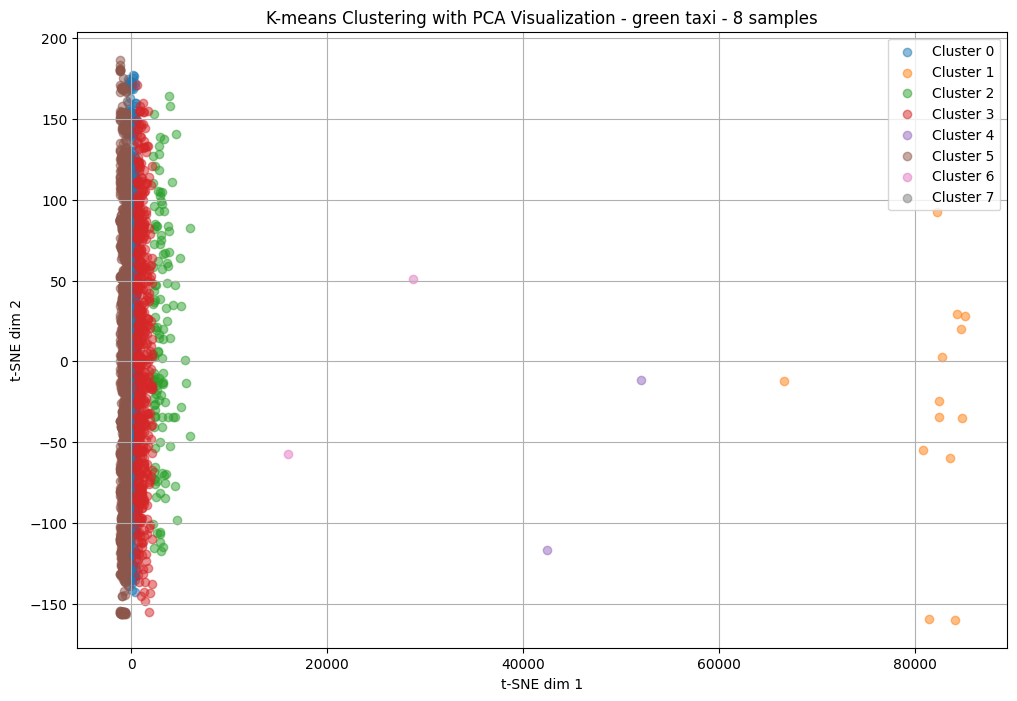

In [23]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(plot_train_df)

plt.figure(figsize=(12, 8))
for i in range(clusters_num):
    plt.scatter(X_pca[cluster_labels == i, 0], X_pca[cluster_labels == i, 1], label=f'Cluster {i}', alpha=0.5)
    
plt.title(f'K-means Clustering with PCA Visualization - green taxi - {clusters_num} clusters')
plt.xlabel('t-SNE dim 1')
plt.ylabel('t-SNE dim 2')
plt.legend()
plt.grid(True)
plt.show()

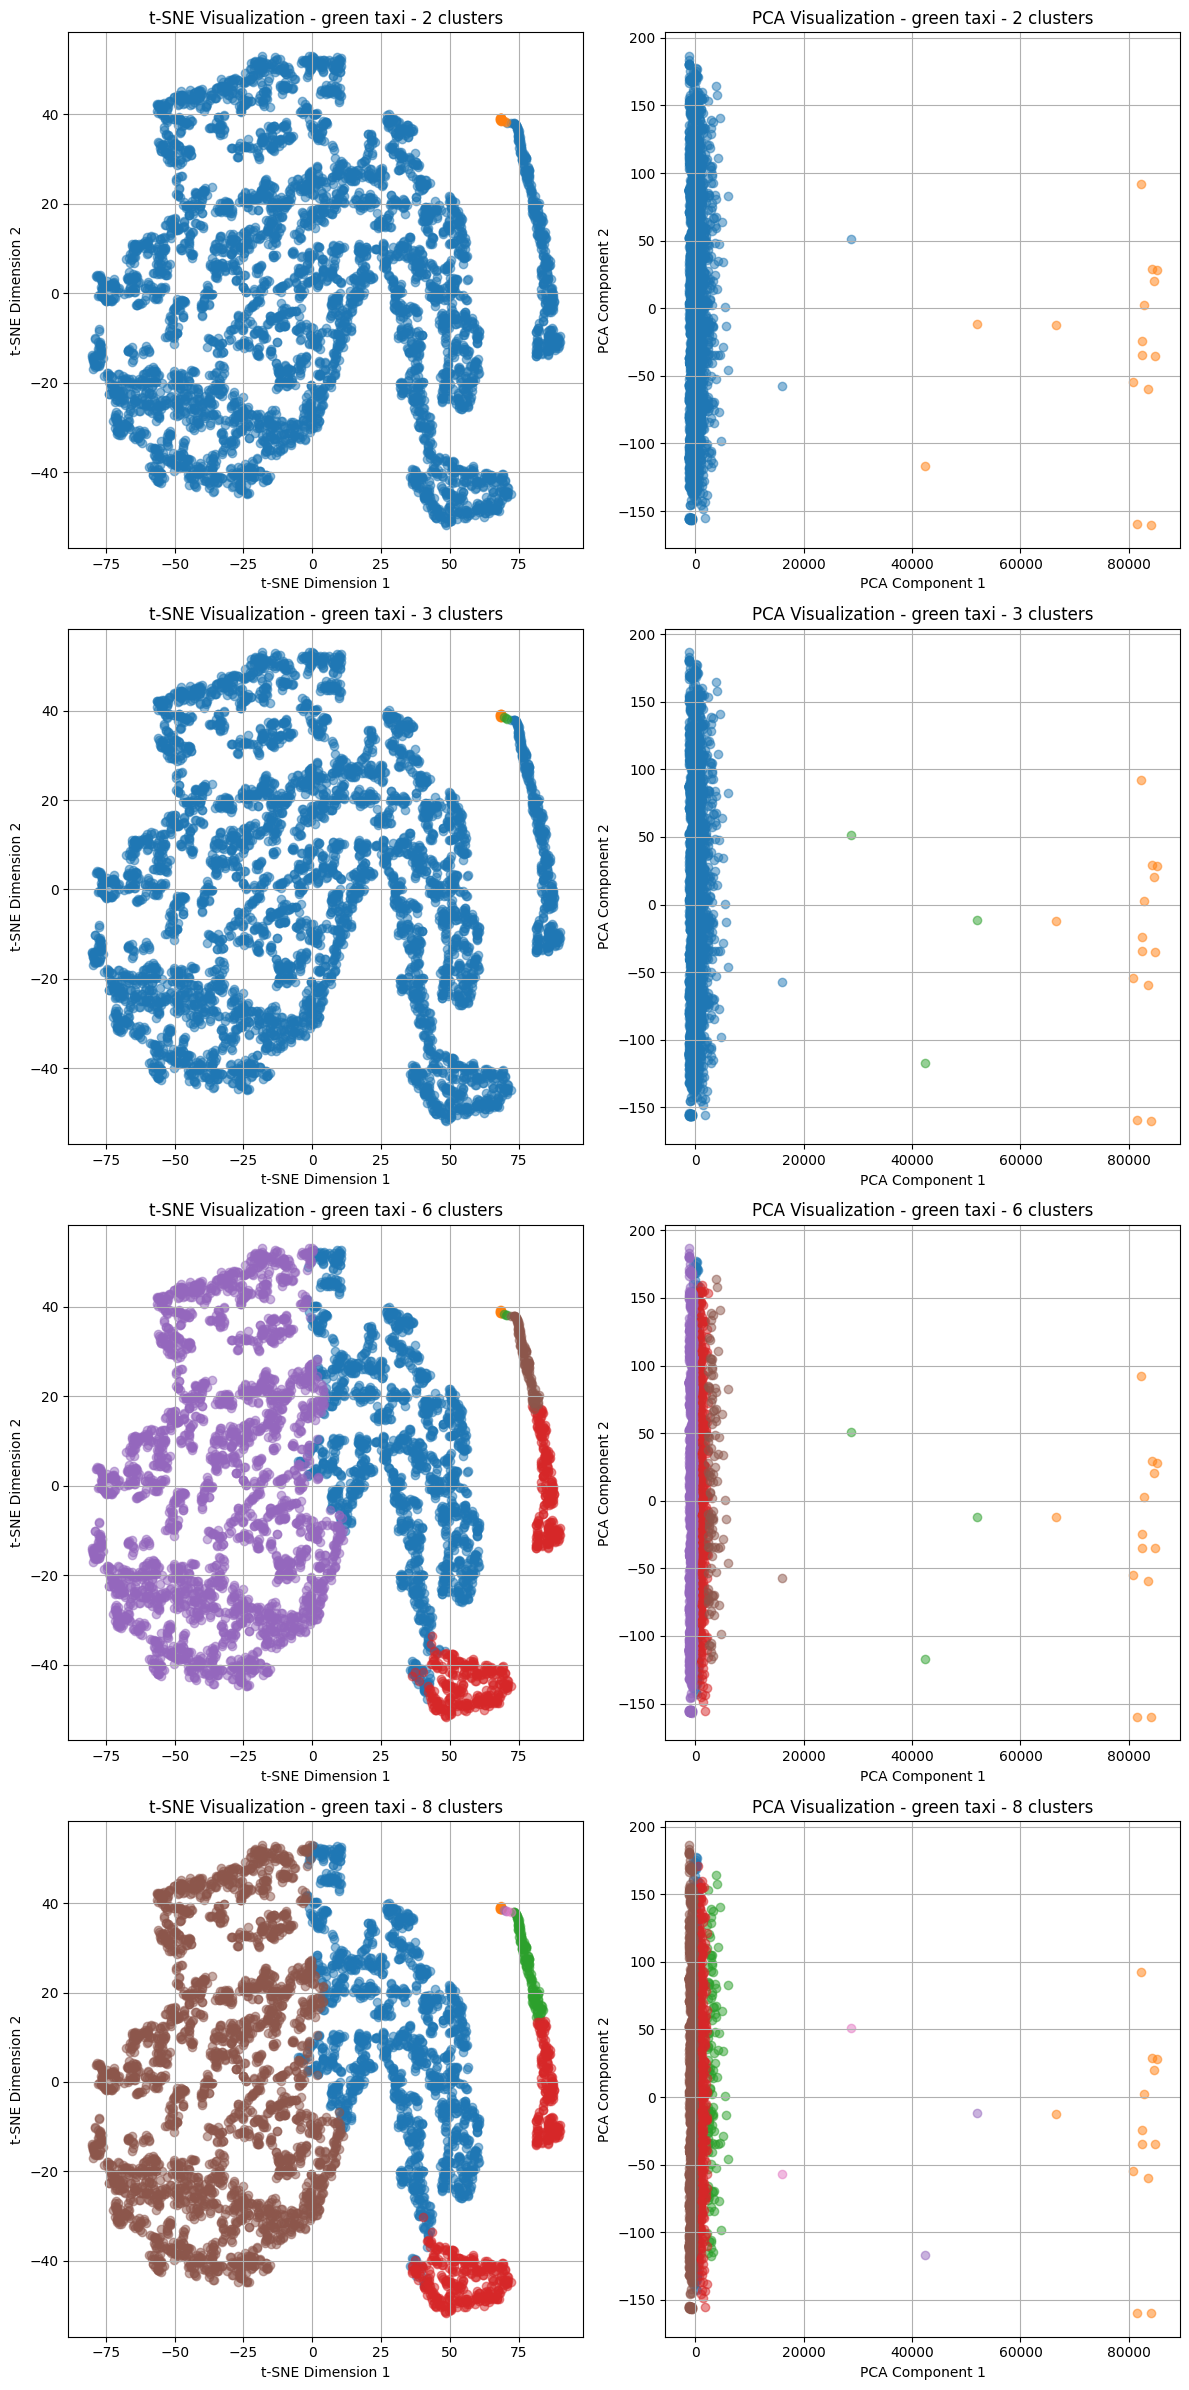

In [31]:
cluster_nums = [2, 3, 6, 8]

fig, axs = plt.subplots(len(cluster_nums), 2, figsize=(12, 24))

for j, clusters_num in enumerate(cluster_nums):
    kmeans = KMeans(n_clusters=clusters_num, n_init="auto", random_state=42).fit(train_df)
    cluster_labels = kmeans.predict(plot_train_df)

    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(plot_train_df)

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(plot_train_df)

    axs[j, 0].set_title(f't-SNE Visualization - green taxi - {clusters_num} clusters')
    for i in range(clusters_num):
        axs[j, 0].scatter(X_tsne[cluster_labels == i, 0], X_tsne[cluster_labels == i, 1], label=f'Cluster {i}', alpha=0.5)
    axs[j, 0].set_xlabel('t-SNE Dimension 1')
    axs[j, 0].set_ylabel('t-SNE Dimension 2')
    # axs[j, 0].legend()
    axs[j, 0].grid(True)

    axs[j, 1].set_title(f'PCA Visualization - green taxi - {clusters_num} clusters')
    for i in range(clusters_num):
        axs[j, 1].scatter(X_pca[cluster_labels == i, 0], X_pca[cluster_labels == i, 1], label=f'Cluster {i}', alpha=0.5)
    axs[j, 1].set_xlabel('PCA Component 1')
    axs[j, 1].set_ylabel('PCA Component 2')
    # axs[j, 1].legend()
    axs[j, 1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
#TODO - try also for yellow taxi and fhv 
#TODO - try also other clustering methods (eg. Agglomerative Clustering, DBScan)
#TODO - check what is in outlier values

## Yellow taxi

In [36]:
train_df = pd.read_parquet(base_path + 'yellow_train_1M.parquet')
train_df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         1  2019-02-15 12:27:24   2019-02-15 12:31:48              1.0   
1         2  2019-02-22 17:52:12   2019-02-22 18:04:09              1.0   
2         1  2019-02-25 02:33:32   2019-02-25 02:47:11              1.0   
3         2  2019-02-03 19:43:24   2019-02-03 19:52:12              2.0   
4         2  2019-02-22 08:55:42   2019-02-22 08:58:11              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           0.50         1.0                  N           229           237   
1           1.25         1.0                  N           142           230   
2           3.60         1.0                  N           186           236   
3           1.68         1.0                  N           141           161   
4           0.48         1.0                  N           236           236   

   payment_type  ...  dew_point_2m (°C)  apparent_temperature (°C)  \
0             1  ...                2.5                        7.1   
1             1  ...               -3.5                        1.2   
2             1  ...               -8.4                       -4.8   
3             1  ...               -0.7                       -2.9   
4             1  ...               -4.3                       -2.0   

   precipitation (mm)  rain (mm)  snowfall (cm)  snow_depth (m)  \
0                 0.0        0.0            0.0            0.01   
1                 0.0        0.0            0.0            0.02   
2                 0.0        0.0            0.0            0.00   
3                 0.0        0.0            0.0            0.00   
4                 0.0        0.0            0.0            0.03   

   surface_pressure (hPa)  cloud_cover (%)  wind_speed_10m (km/h)  is_day ()  
0                  1001.1               56                   19.5          1  
1                  1022.4               30                   10.2          1  
2                   994.8              100                   33.3          0  
3                  1013.2               10                    8.6          0  
4                  1020.4               30                   11.4          1  

[5 rows x 32 columns]

In [37]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999969 entries, 0 to 999968
Data columns (total 32 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   VendorID                   999969 non-null  int64         
 1   tpep_pickup_datetime       999969 non-null  datetime64[ns]
 2   tpep_dropoff_datetime      999969 non-null  datetime64[ns]
 3   passenger_count            999969 non-null  float64       
 4   trip_distance              999969 non-null  float64       
 5   RatecodeID                 999969 non-null  float64       
 6   store_and_fwd_flag         999969 non-null  object        
 7   PULocationID               999969 non-null  int64         
 8   DOLocationID               999969 non-null  int64         
 9   payment_type               999969 non-null  int64         
 10  fare_amount                999969 non-null  float64       
 11  extra                      999969 non-null  float64 

<Axes: >

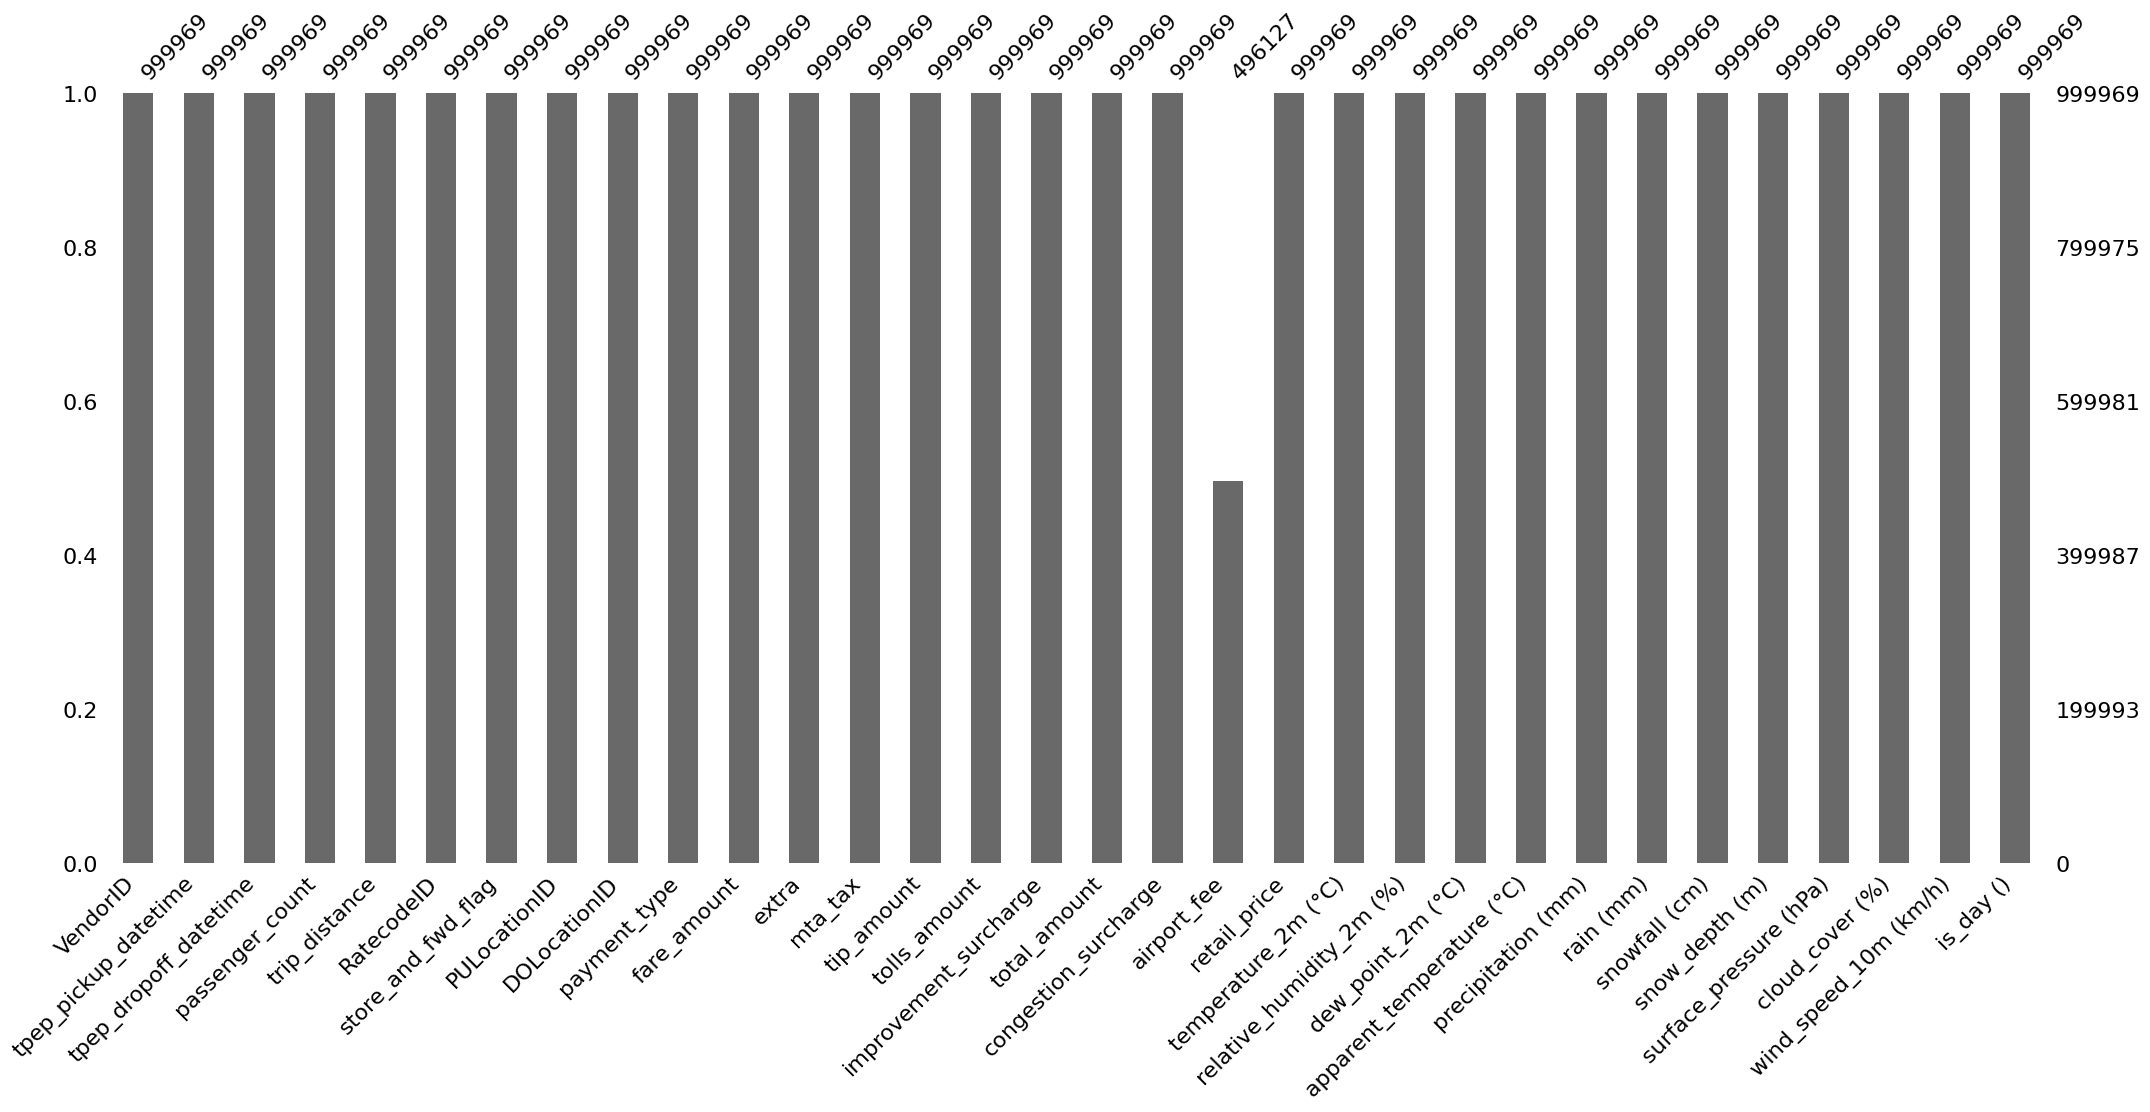

In [38]:
msno.bar(train_df)

In [39]:
train_df['store_and_fwd_flag'] = train_df['store_and_fwd_flag'] == 'Y'
train_df['store_and_fwd_flag'] = train_df['store_and_fwd_flag'].astype(int)

# add new time-connected columns
train_df['trip_time'] = train_df['tpep_dropoff_datetime'] - train_df['tpep_pickup_datetime']
train_df['trip_time'] = train_df['trip_time'].values.astype(float)//10**9

train_df['year'] = train_df['tpep_pickup_datetime'].dt.year
train_df['month'] = train_df['tpep_pickup_datetime'].dt.month
train_df['weekday'] = train_df['tpep_pickup_datetime'].dt.weekday
train_df['hour'] = train_df['tpep_pickup_datetime'].dt.hour

train_df = train_df.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'airport_fee'])

In [40]:
train_df.head()

VendorID  passenger_count  trip_distance  RatecodeID  store_and_fwd_flag  \
0         1              1.0           0.50         1.0                   0   
1         2              1.0           1.25         1.0                   0   
2         1              1.0           3.60         1.0                   0   
3         2              2.0           1.68         1.0                   0   
4         2              1.0           0.48         1.0                   0   

   PULocationID  DOLocationID  payment_type  fare_amount  extra  ...  \
0           229           237             1          4.5    2.5  ...   
1           142           230             1          9.0    1.0  ...   
2           186           236             1         13.5    3.0  ...   
3           141           161             1          8.5    0.0  ...   
4           236           236             1          4.0    0.0  ...   

   snow_depth (m)  surface_pressure (hPa)  cloud_cover (%)  \
0            0.01                  1001.1               56   
1            0.02                  1022.4               30   
2            0.00                   994.8              100   
3            0.00                  1013.2               10   
4            0.03                  1020.4               30   

   wind_speed_10m (km/h)  is_day ()  trip_time  year  month  weekday  hour  
0                   19.5          1      264.0  2019      2        4    12  
1                   10.2          1      717.0  2019      2        4    17  
2                   33.3          0      819.0  2019      2        0     2  
3                    8.6          0      528.0  2019      2        6    19  
4                   11.4          1      149.0  2019      2        4     8  

[5 rows x 34 columns]

In [41]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999969 entries, 0 to 999968
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   VendorID                   999969 non-null  int64  
 1   passenger_count            999969 non-null  float64
 2   trip_distance              999969 non-null  float64
 3   RatecodeID                 999969 non-null  float64
 4   store_and_fwd_flag         999969 non-null  int32  
 5   PULocationID               999969 non-null  int64  
 6   DOLocationID               999969 non-null  int64  
 7   payment_type               999969 non-null  int64  
 8   fare_amount                999969 non-null  float64
 9   extra                      999969 non-null  float64
 10  mta_tax                    999969 non-null  float64
 11  tip_amount                 999969 non-null  float64
 12  tolls_amount               999969 non-null  float64
 13  improvement_surcharge      99

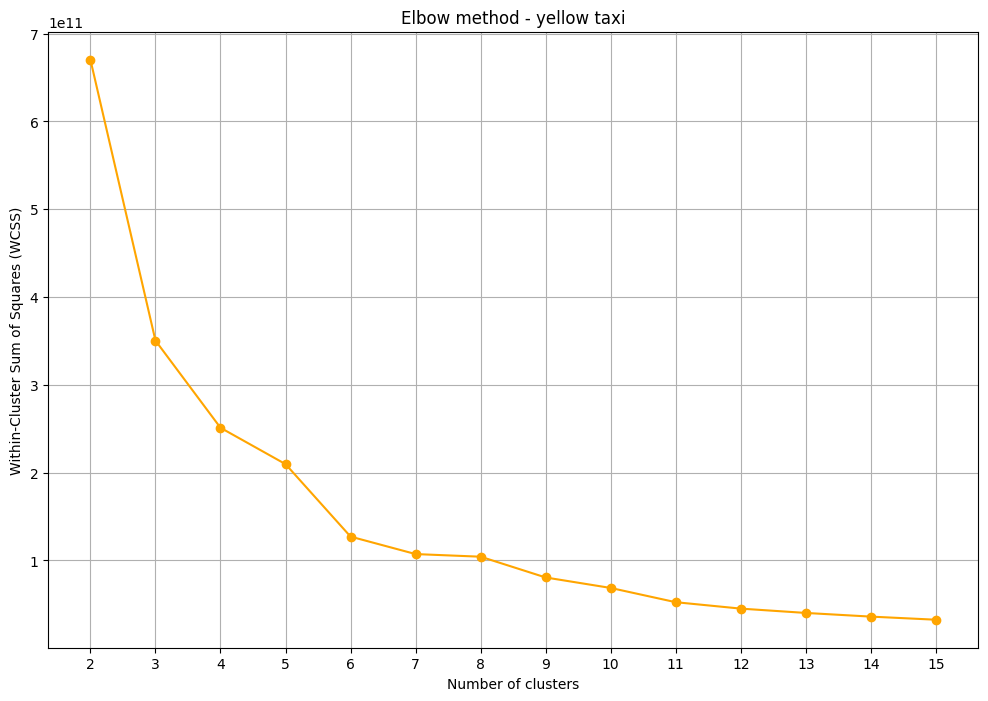

In [42]:
max_clusters = 16

wcss = []
for i in range(2, max_clusters):
    kmeans = KMeans(n_clusters=i, n_init="auto", random_state=42).fit(train_df)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(12, 8))
plt.plot(range(2, max_clusters), wcss, marker='o', linestyle='-', color='orange')
plt.title('Elbow method - yellow taxi')
plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(range(2, max_clusters))
plt.grid(True)
plt.show()

In [43]:
n_samples = 10 ** 4
smaller_train_df = train_df.sample(n_samples)

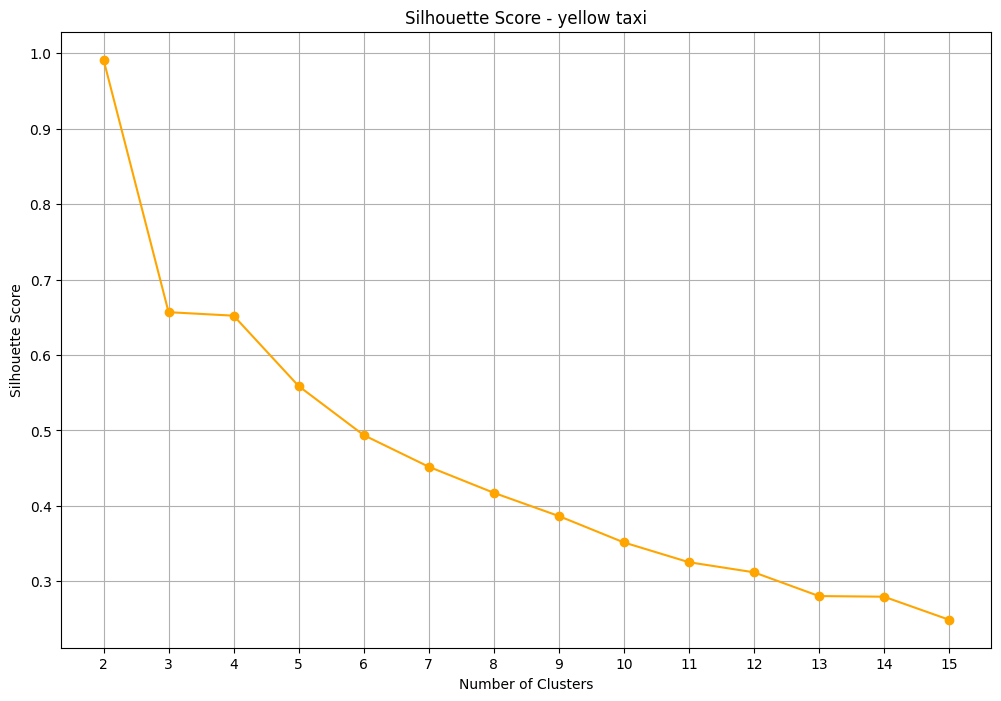

In [47]:
silhouette_scores = []

for i in range(2, max_clusters):
    kmeans = KMeans(n_clusters=i, n_init="auto", random_state=42)
    cluster_labels = kmeans.fit_predict(smaller_train_df)
    silhouette_avg = silhouette_score(smaller_train_df, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(12, 8))
plt.plot(range(2, max_clusters), silhouette_scores, marker='o', linestyle='-', color='orange')
plt.title('Silhouette Score - yellow taxi')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, max_clusters))
plt.grid(True)
plt.show()

In [45]:
n_samples = 5000

plot_train_df = train_df.sample(n_samples, random_state=42)

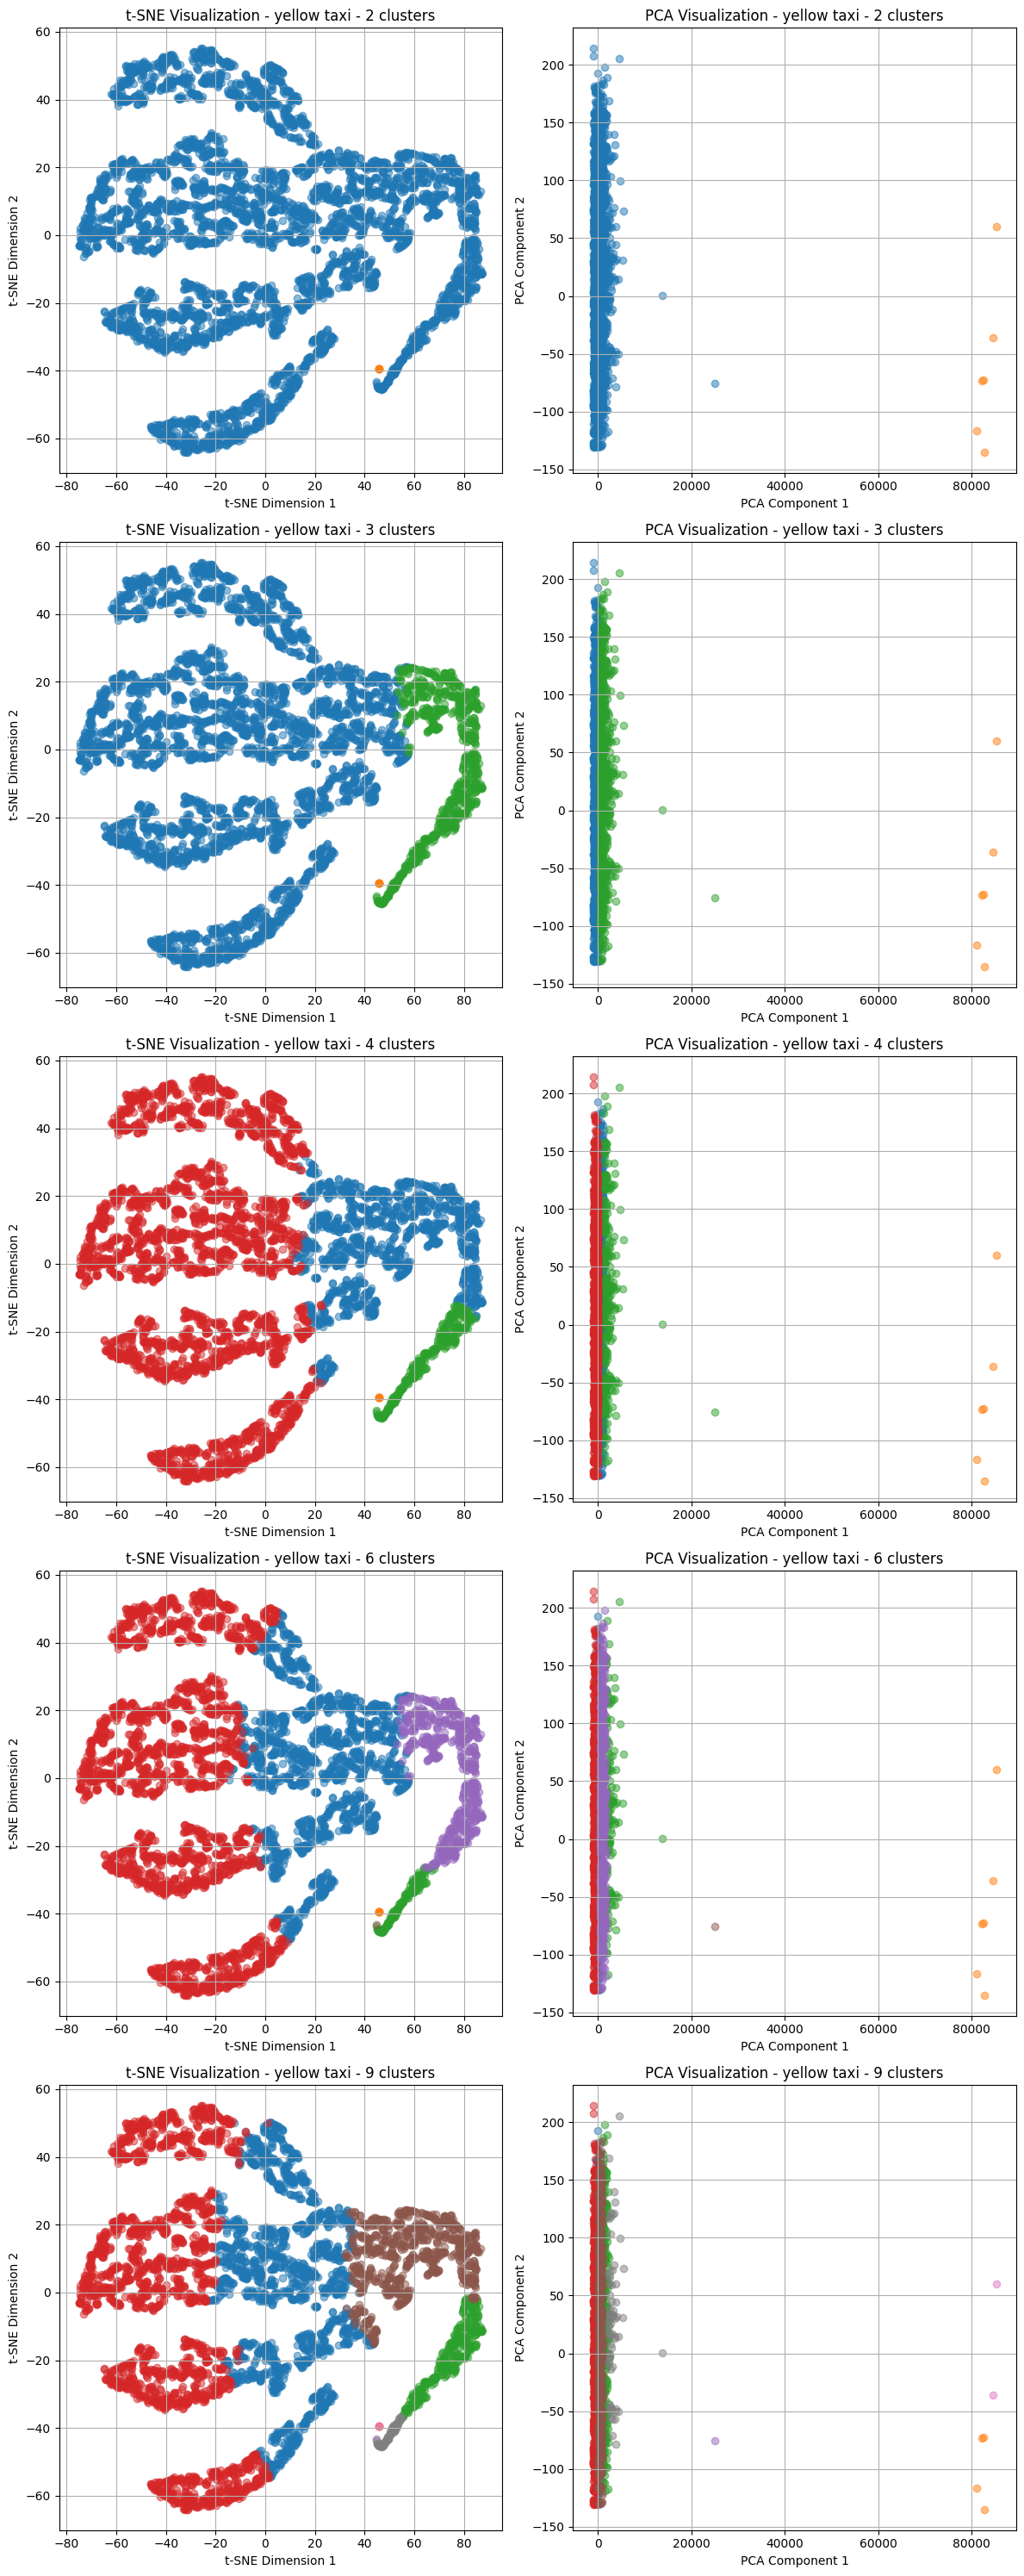

In [48]:
cluster_nums = [2, 3, 4, 6, 9]

fig, axs = plt.subplots(len(cluster_nums), 2, figsize=(12, 30))

for j, clusters_num in enumerate(cluster_nums):
    kmeans = KMeans(n_clusters=clusters_num, n_init="auto", random_state=42).fit(train_df)
    cluster_labels = kmeans.predict(plot_train_df)

    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(plot_train_df)

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(plot_train_df)

    axs[j, 0].set_title(f't-SNE Visualization - yellow taxi - {clusters_num} clusters')
    for i in range(clusters_num):
        axs[j, 0].scatter(X_tsne[cluster_labels == i, 0], X_tsne[cluster_labels == i, 1], label=f'Cluster {i}', alpha=0.5)
    axs[j, 0].set_xlabel('t-SNE Dimension 1')
    axs[j, 0].set_ylabel('t-SNE Dimension 2')
    # axs[j, 0].legend()
    axs[j, 0].grid(True)

    axs[j, 1].set_title(f'PCA Visualization - yellow taxi - {clusters_num} clusters')
    for i in range(clusters_num):
        axs[j, 1].scatter(X_pca[cluster_labels == i, 0], X_pca[cluster_labels == i, 1], label=f'Cluster {i}', alpha=0.5)
    axs[j, 1].set_xlabel('PCA Component 1')
    axs[j, 1].set_ylabel('PCA Component 2')
    # axs[j, 1].legend()
    axs[j, 1].grid(True)

plt.tight_layout()
plt.show()

## FHV

In [104]:
train_df = pd.read_parquet(base_path + 'fhv_train_1M.parquet')
train_df.head()

hvfhs_license_num dispatching_base_num originating_base_num  \
0            HV0003               B02764               B02764   
1            HV0003               B02866               B02866   
2            HV0003               B02866               B02866   
3            HV0003               B02875               B02875   
4            HV0002               B02914               B02914   

     request_datetime   on_scene_datetime     pickup_datetime  \
0 2019-02-09 08:01:12 2019-02-09 08:06:35 2019-02-09 08:08:19   
1 2019-02-26 21:59:29 2019-02-26 22:05:24 2019-02-26 22:06:47   
2 2019-02-08 09:05:02 2019-02-08 09:05:37 2019-02-08 09:12:58   
3 2019-02-03 23:04:43 2019-02-03 23:09:40 2019-02-03 23:11:21   
4 2019-02-22 23:08:37                 NaT 2019-02-22 23:15:33   

     dropoff_datetime  PULocationID  DOLocationID  trip_miles  ...  \
0 2019-02-09 08:38:14            37            62        4.76  ...   
1 2019-02-26 22:19:38           113             4        1.41  ...   
2 2019-02-08 09:34:44           170           114        2.64  ...   
3 2019-02-03 23:31:54           164            79        3.63  ...   
4 2019-02-22 23:20:42           210           123        1.45  ...   

   dew_point_2m (°C)  apparent_temperature (°C)  precipitation (mm)  \
0              -14.8                      -11.6                 0.0   
1              -13.7                       -9.4                 0.0   
2                4.1                        1.3                 1.7   
3               -1.5                       -4.0                 0.0   
4               -5.4                       -3.8                 0.0   

   rain (mm)  snowfall (cm)  snow_depth (m)  surface_pressure (hPa)  \
0        0.0            0.0            0.00                  1027.0   
1        0.0            0.0            0.00                  1024.4   
2        1.7            0.0            0.00                  1006.7   
3        0.0            0.0            0.00                  1013.7   
4        0.0            0.0            0.02                  1024.5   

   cloud_cover (%)  wind_speed_10m (km/h) is_day ()  
0               10                   20.7         1  
1               18                   14.8         0  
2               91                   11.9         1  
3                1                    8.9         0  
4               30                    8.9         0  

[5 rows x 37 columns]

In [105]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999967 entries, 0 to 999966
Data columns (total 37 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   hvfhs_license_num          999967 non-null  object        
 1   dispatching_base_num       999961 non-null  object        
 2   originating_base_num       724907 non-null  object        
 3   request_datetime           999849 non-null  datetime64[ns]
 4   on_scene_datetime          721421 non-null  datetime64[ns]
 5   pickup_datetime            999967 non-null  datetime64[ns]
 6   dropoff_datetime           999967 non-null  datetime64[ns]
 7   PULocationID               999967 non-null  int64         
 8   DOLocationID               999967 non-null  int64         
 9   trip_miles                 999967 non-null  float64       
 10  trip_time                  999967 non-null  int64         
 11  base_passenger_fare        999967 non-null  float64 

In [106]:
train_df.columns

Index(['hvfhs_license_num', 'dispatching_base_num', 'originating_base_num',
       'request_datetime', 'on_scene_datetime', 'pickup_datetime',
       'dropoff_datetime', 'PULocationID', 'DOLocationID', 'trip_miles',
       'trip_time', 'base_passenger_fare', 'tolls', 'bcf', 'sales_tax',
       'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay',
       'shared_request_flag', 'shared_match_flag', 'access_a_ride_flag',
       'wav_request_flag', 'wav_match_flag', 'retail_price',
       'temperature_2m (°C)', 'relative_humidity_2m (%)', 'dew_point_2m (°C)',
       'apparent_temperature (°C)', 'precipitation (mm)', 'rain (mm)',
       'snowfall (cm)', 'snow_depth (m)', 'surface_pressure (hPa)',
       'cloud_cover (%)', 'wind_speed_10m (km/h)', 'is_day ()'],
      dtype='object')

In [107]:
train_df['trip_time'] = train_df['dropoff_datetime'] - train_df['pickup_datetime']
train_df['trip_time'] = train_df['trip_time'].values.astype(float)//10**9

train_df['wait_time'] = train_df['pickup_datetime'] - train_df['request_datetime']
train_df['wait_time'] = train_df['trip_time'].values.astype(float)//10**9

train_df['year'] = train_df['pickup_datetime'].dt.year
train_df['month'] = train_df['pickup_datetime'].dt.month
train_df['weekday'] = train_df['pickup_datetime'].dt.weekday
train_df['hour'] = train_df['pickup_datetime'].dt.hour

train_df = train_df.drop(columns=['hvfhs_license_num', 'dispatching_base_num', 'originating_base_num', 'airport_fee',
                                 'request_datetime', 'on_scene_datetime', 'pickup_datetime', 'dropoff_datetime',])

In [108]:
train_df.head()

PULocationID  DOLocationID  trip_miles  trip_time  base_passenger_fare  \
0            37            62        4.76     1795.0                 5.46   
1           113             4        1.41      771.0                 5.25   
2           170           114        2.64     1306.0                19.12   
3           164            79        3.63     1233.0                 4.75   
4           210           123        1.45      309.0                 5.66   

   tolls   bcf  sales_tax  congestion_surcharge  tips  ...  snow_depth (m)  \
0    0.0  0.14       0.48                  0.00   0.0  ...            0.00   
1    0.0  0.16       0.56                  2.75   0.0  ...            0.00   
2    0.0  0.48       1.70                  2.75   0.0  ...            0.00   
3    0.0  0.13       0.45                  0.75   0.0  ...            0.00   
4    0.0  0.14       0.50                   NaN   0.0  ...            0.02   

  surface_pressure (hPa) cloud_cover (%) wind_speed_10m (km/h) is_day ()  \
0                 1027.0              10                  20.7         1   
1                 1024.4              18                  14.8         0   
2                 1006.7              91                  11.9         1   
3                 1013.7               1                   8.9         0   
4                 1024.5              30                   8.9         0   

  wait_time  year  month  weekday  hour  
0       0.0  2019      2        5     8  
1       0.0  2019      2        1    22  
2       0.0  2019      2        4     9  
3       0.0  2019      2        6    23  
4       0.0  2019      2        4    23  

[5 rows x 34 columns]

In [109]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999967 entries, 0 to 999966
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   PULocationID               999967 non-null  int64  
 1   DOLocationID               999967 non-null  int64  
 2   trip_miles                 999967 non-null  float64
 3   trip_time                  999967 non-null  float64
 4   base_passenger_fare        999967 non-null  float64
 5   tolls                      999967 non-null  float64
 6   bcf                        999967 non-null  float64
 7   sales_tax                  999967 non-null  float64
 8   congestion_surcharge       999418 non-null  float64
 9   tips                       999967 non-null  float64
 10  driver_pay                 999967 non-null  float64
 11  shared_request_flag        999967 non-null  object 
 12  shared_match_flag          999967 non-null  object 
 13  access_a_ride_flag         99

In [111]:
for col_name in ['shared_request_flag', 'shared_match_flag', 'access_a_ride_flag', 'wav_request_flag', 'wav_match_flag']:
    train_df[col_name] = train_df[col_name].replace(' ', np.nan)
    print(train_df[col_name].unique())

['Y' 'N']
['Y' 'N']
['N' nan 'Y']
['N' 'Y']
[None nan 'N' 'Y']


In [112]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999967 entries, 0 to 999966
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   PULocationID               999967 non-null  int64  
 1   DOLocationID               999967 non-null  int64  
 2   trip_miles                 999967 non-null  float64
 3   trip_time                  999967 non-null  float64
 4   base_passenger_fare        999967 non-null  float64
 5   tolls                      999967 non-null  float64
 6   bcf                        999967 non-null  float64
 7   sales_tax                  999967 non-null  float64
 8   congestion_surcharge       999418 non-null  float64
 9   tips                       999967 non-null  float64
 10  driver_pay                 999967 non-null  float64
 11  shared_request_flag        999967 non-null  object 
 12  shared_match_flag          999967 non-null  object 
 13  access_a_ride_flag         36

In [113]:
train_df = train_df.drop(columns=['access_a_ride_flag', 'wav_match_flag'])

In [114]:
train_df = train_df.dropna().copy()

In [115]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999418 entries, 0 to 999966
Data columns (total 32 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   PULocationID               999418 non-null  int64  
 1   DOLocationID               999418 non-null  int64  
 2   trip_miles                 999418 non-null  float64
 3   trip_time                  999418 non-null  float64
 4   base_passenger_fare        999418 non-null  float64
 5   tolls                      999418 non-null  float64
 6   bcf                        999418 non-null  float64
 7   sales_tax                  999418 non-null  float64
 8   congestion_surcharge       999418 non-null  float64
 9   tips                       999418 non-null  float64
 10  driver_pay                 999418 non-null  float64
 11  shared_request_flag        999418 non-null  object 
 12  shared_match_flag          999418 non-null  object 
 13  wav_request_flag           99

In [116]:
for col_name in ['shared_request_flag', 'shared_match_flag', 'wav_request_flag']:
    train_df[col_name] = train_df[col_name] == 'Y'
    train_df[col_name] = train_df[col_name].astype(int)

In [117]:
train_df.head()

PULocationID  DOLocationID  trip_miles  trip_time  base_passenger_fare  \
0            37            62        4.76     1795.0                 5.46   
1           113             4        1.41      771.0                 5.25   
2           170           114        2.64     1306.0                19.12   
3           164            79        3.63     1233.0                 4.75   
5           237            92       13.66     2302.0                37.31   

   tolls   bcf  sales_tax  congestion_surcharge  tips  ...  snow_depth (m)  \
0   0.00  0.14       0.48                  0.00   0.0  ...            0.00   
1   0.00  0.16       0.56                  2.75   0.0  ...            0.00   
2   0.00  0.48       1.70                  2.75   0.0  ...            0.00   
3   0.00  0.13       0.45                  0.75   0.0  ...            0.00   
5   5.76  1.09       3.86                  2.75   0.0  ...            0.01   

   surface_pressure (hPa)  cloud_cover (%)  wind_speed_10m (km/h)  is_day ()  \
0                  1027.0               10                   20.7          1   
1                  1024.4               18                   14.8          0   
2                  1006.7               91                   11.9          1   
3                  1013.7                1                    8.9          0   
5                  1014.1               15                   23.8          1   

   wait_time  year  month  weekday  hour  
0        0.0  2019      2        5     8  
1        0.0  2019      2        1    22  
2        0.0  2019      2        4     9  
3        0.0  2019      2        6    23  
5        0.0  2019      2        5    15  

[5 rows x 32 columns]

In [118]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999418 entries, 0 to 999966
Data columns (total 32 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   PULocationID               999418 non-null  int64  
 1   DOLocationID               999418 non-null  int64  
 2   trip_miles                 999418 non-null  float64
 3   trip_time                  999418 non-null  float64
 4   base_passenger_fare        999418 non-null  float64
 5   tolls                      999418 non-null  float64
 6   bcf                        999418 non-null  float64
 7   sales_tax                  999418 non-null  float64
 8   congestion_surcharge       999418 non-null  float64
 9   tips                       999418 non-null  float64
 10  driver_pay                 999418 non-null  float64
 11  shared_request_flag        999418 non-null  int32  
 12  shared_match_flag          999418 non-null  int32  
 13  wav_request_flag           99

In [119]:
n_samples = 10 ** 4
smaller_train_df = train_df.sample(n_samples)

In [120]:
n_samples = 5000
plot_train_df = train_df.sample(n_samples, random_state=42)

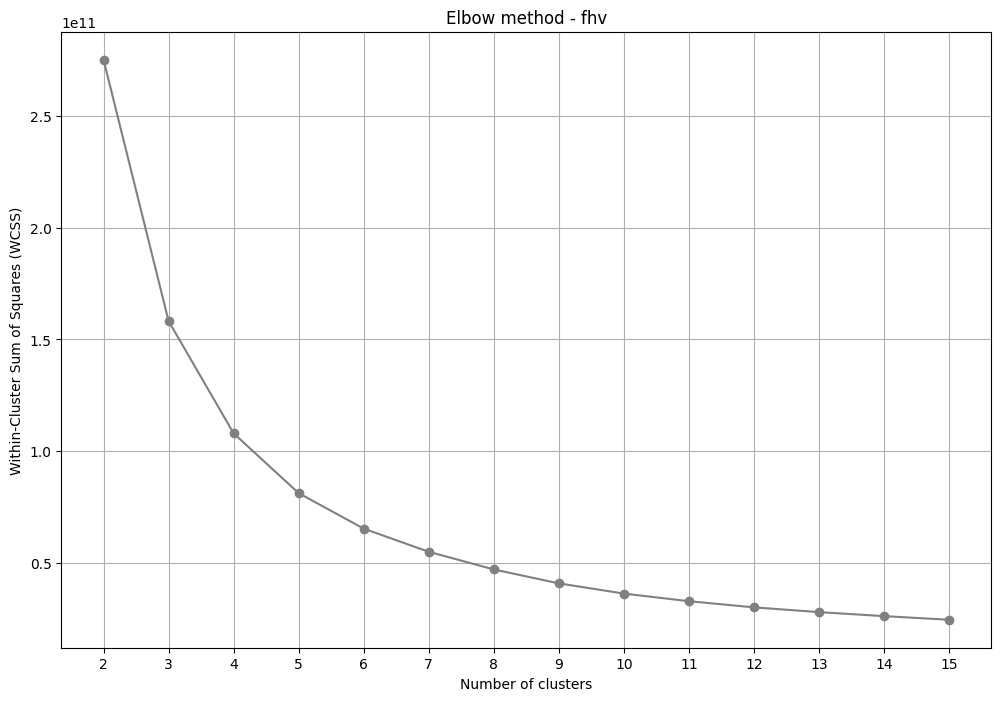

In [121]:
max_clusters = 16

wcss = []
for i in range(2, max_clusters):
    kmeans = KMeans(n_clusters=i, n_init="auto", random_state=42).fit(train_df)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(12, 8))
plt.plot(range(2, max_clusters), wcss, marker='o', linestyle='-', color='gray')
plt.title('Elbow method - fhv')
plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(range(2, max_clusters))
plt.grid(True)
plt.show()

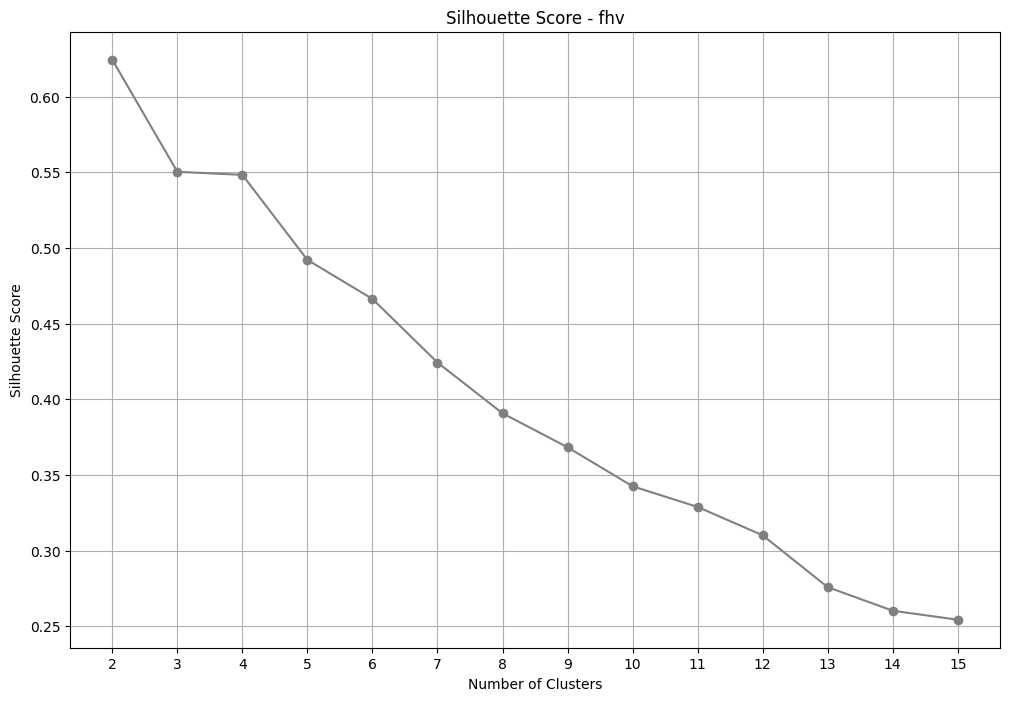

In [122]:
silhouette_scores = []

for i in range(2, max_clusters):
    kmeans = KMeans(n_clusters=i, n_init="auto", random_state=42)
    cluster_labels = kmeans.fit_predict(smaller_train_df)
    silhouette_avg = silhouette_score(smaller_train_df, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(12, 8))
plt.plot(range(2, max_clusters), silhouette_scores, marker='o', linestyle='-', color='gray')
plt.title('Silhouette Score - fhv')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, max_clusters))
plt.grid(True)
plt.show()

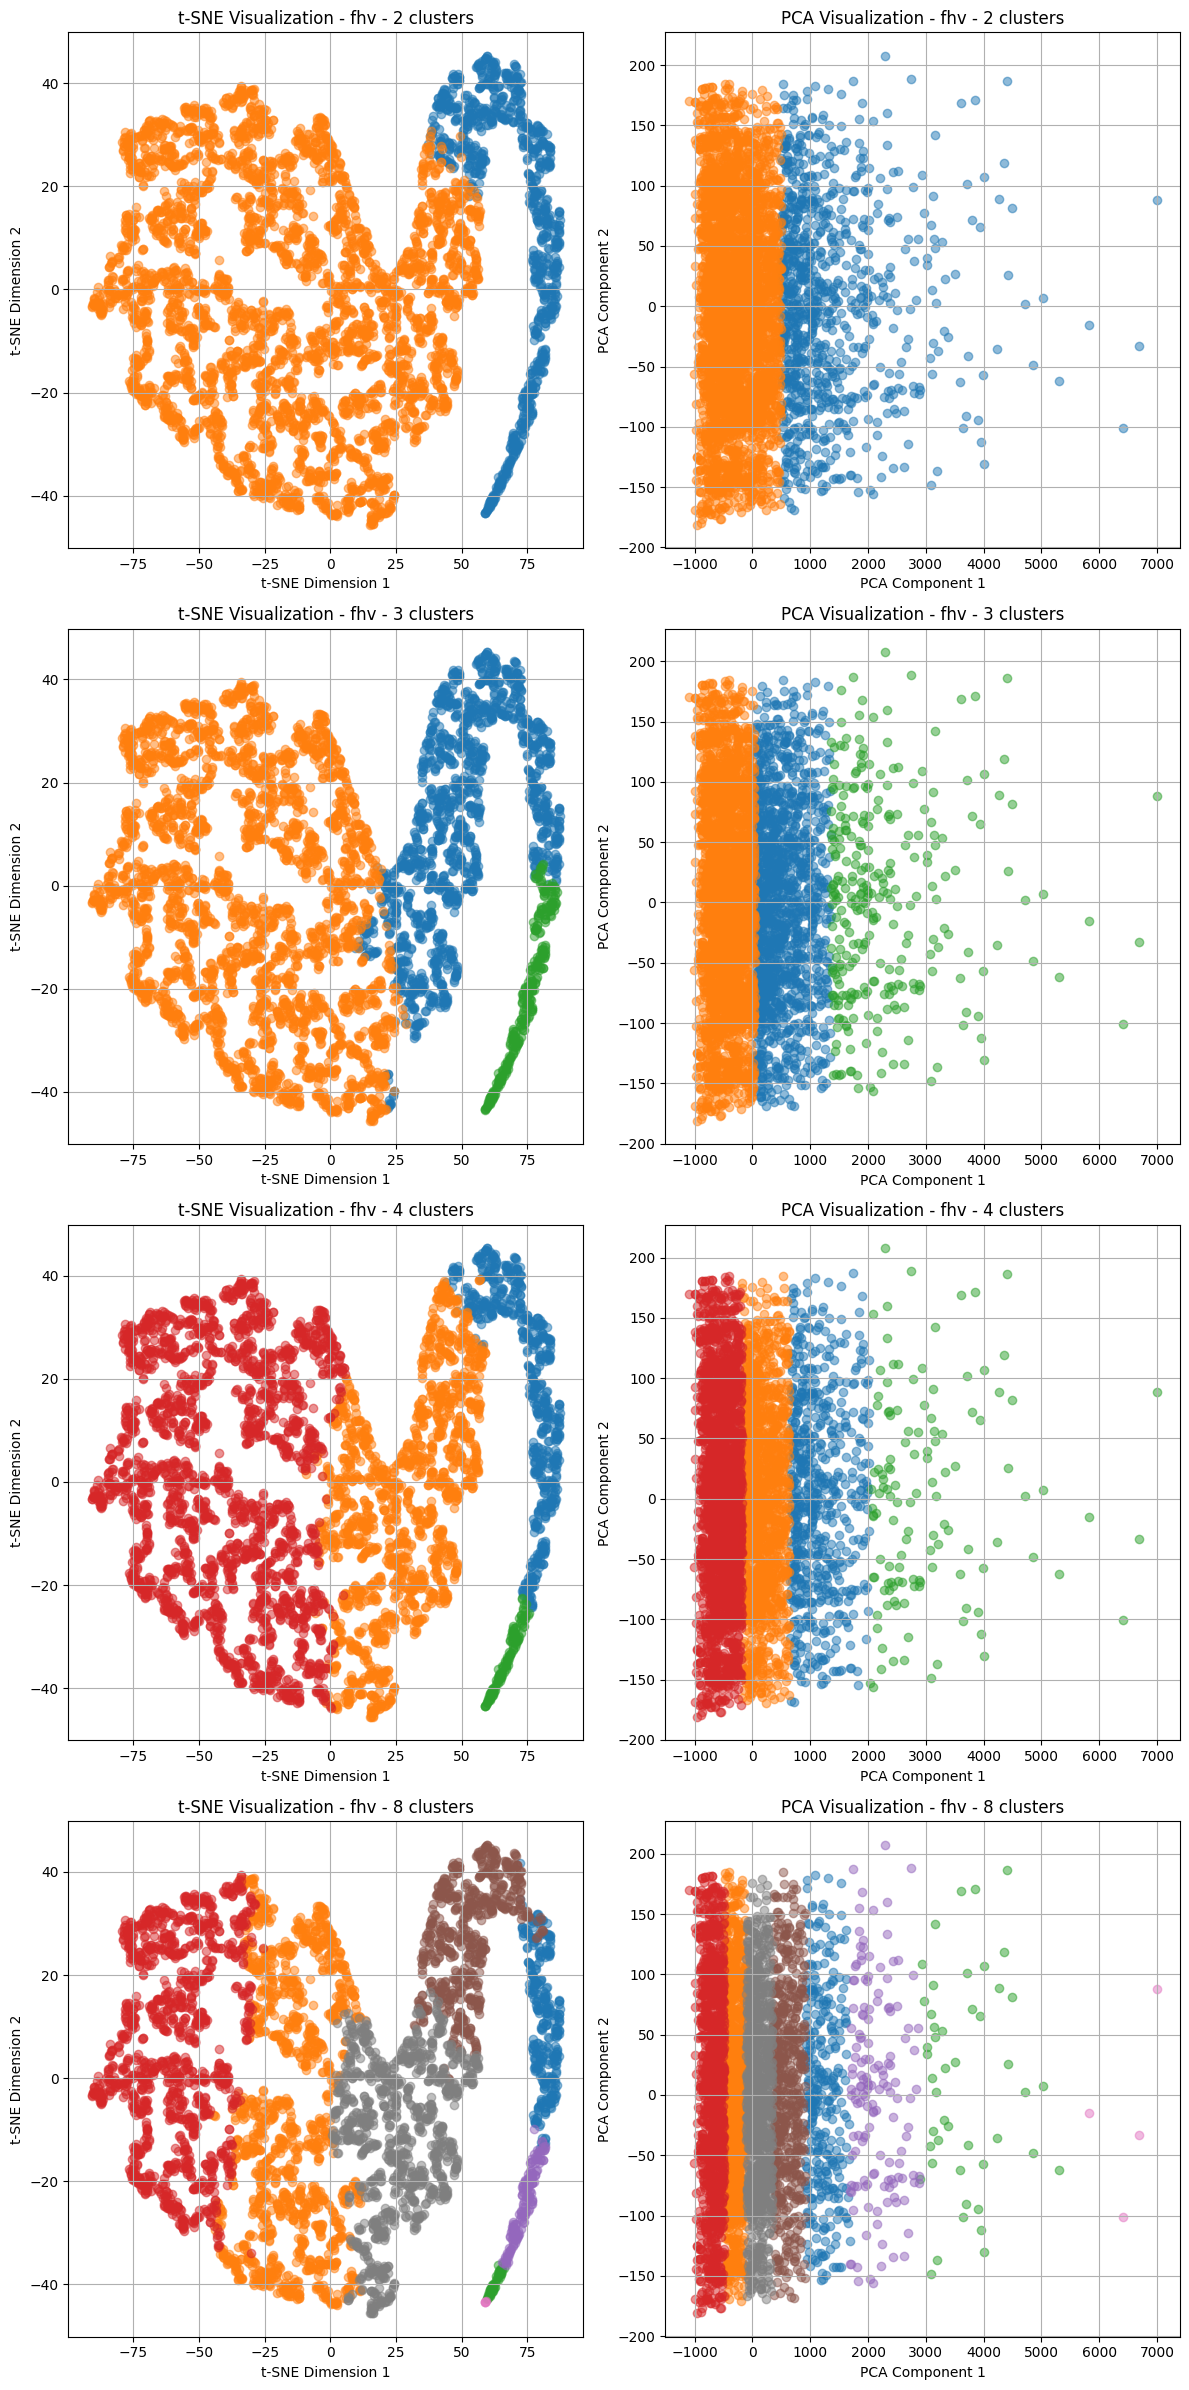

In [123]:
cluster_nums = [2, 3, 4, 8]

fig, axs = plt.subplots(len(cluster_nums), 2, figsize=(12, 6*len(cluster_nums)))

for j, clusters_num in enumerate(cluster_nums):
    kmeans = KMeans(n_clusters=clusters_num, n_init="auto", random_state=42).fit(train_df)
    cluster_labels = kmeans.predict(plot_train_df)

    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(plot_train_df)

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(plot_train_df)

    axs[j, 0].set_title(f't-SNE Visualization - fhv - {clusters_num} clusters')
    for i in range(clusters_num):
        axs[j, 0].scatter(X_tsne[cluster_labels == i, 0], X_tsne[cluster_labels == i, 1], label=f'Cluster {i}', alpha=0.5)
    axs[j, 0].set_xlabel('t-SNE Dimension 1')
    axs[j, 0].set_ylabel('t-SNE Dimension 2')
    # axs[j, 0].legend()
    axs[j, 0].grid(True)

    axs[j, 1].set_title(f'PCA Visualization - fhv - {clusters_num} clusters')
    for i in range(clusters_num):
        axs[j, 1].scatter(X_pca[cluster_labels == i, 0], X_pca[cluster_labels == i, 1], label=f'Cluster {i}', alpha=0.5)
    axs[j, 1].set_xlabel('PCA Component 1')
    axs[j, 1].set_ylabel('PCA Component 2')
    # axs[j, 1].legend()
    axs[j, 1].grid(True)

plt.tight_layout()
plt.show()

In [128]:
scaler = MinMaxScaler()
scaled_train_df = pd.DataFrame(scaler.fit_transform(train_df))

In [130]:
scaled_train_df.columns = train_df.columns
scaled_train_df.head()

PULocationID  DOLocationID  trip_miles  trip_time  base_passenger_fare  \
0      0.136364      0.231061    0.012473   0.134755             0.051311   
1      0.424242      0.011364    0.003695   0.107757             0.051161   
2      0.640152      0.428030    0.006918   0.121862             0.061073   
3      0.617424      0.295455    0.009512   0.119938             0.050804   
4      0.893939      0.344697    0.035794   0.148123             0.074073   

      tolls       bcf  sales_tax  congestion_surcharge  tips  ...  \
0  0.000000  0.004187   0.007505              0.000000   0.0  ...   
1  0.000000  0.004785   0.008755              0.500000   0.0  ...   
2  0.000000  0.014354   0.026579              0.500000   0.0  ...   
3  0.000000  0.003888   0.007036              0.136364   0.0  ...   
4  0.072453  0.032596   0.060350              0.500000   0.0  ...   

   snow_depth (m)  surface_pressure (hPa)  cloud_cover (%)  \
0        0.000000                0.873089             0.10   
1        0.000000                0.833333             0.18   
2        0.000000                0.562691             0.91   
3        0.000000                0.669725             0.01   
4        0.033333                0.675841             0.15   

   wind_speed_10m (km/h)  is_day ()  wait_time  year     month   weekday  \
0               0.342715        1.0        1.0   0.0  0.090909  0.833333   
1               0.245033        0.0        1.0   0.0  0.090909  0.166667   
2               0.197020        1.0        1.0   0.0  0.090909  0.666667   
3               0.147351        0.0        1.0   0.0  0.090909  1.000000   
4               0.394040        1.0        1.0   0.0  0.090909  0.833333   

       hour  
0  0.347826  
1  0.956522  
2  0.391304  
3  1.000000  
4  0.652174  

[5 rows x 32 columns]

In [131]:
n_samples = 10 ** 4
scaled_smaller_train_df = scaled_train_df.sample(n_samples)

In [132]:
n_samples = 5000
scaled_plot_train_df = scaled_train_df.sample(n_samples, random_state=42)

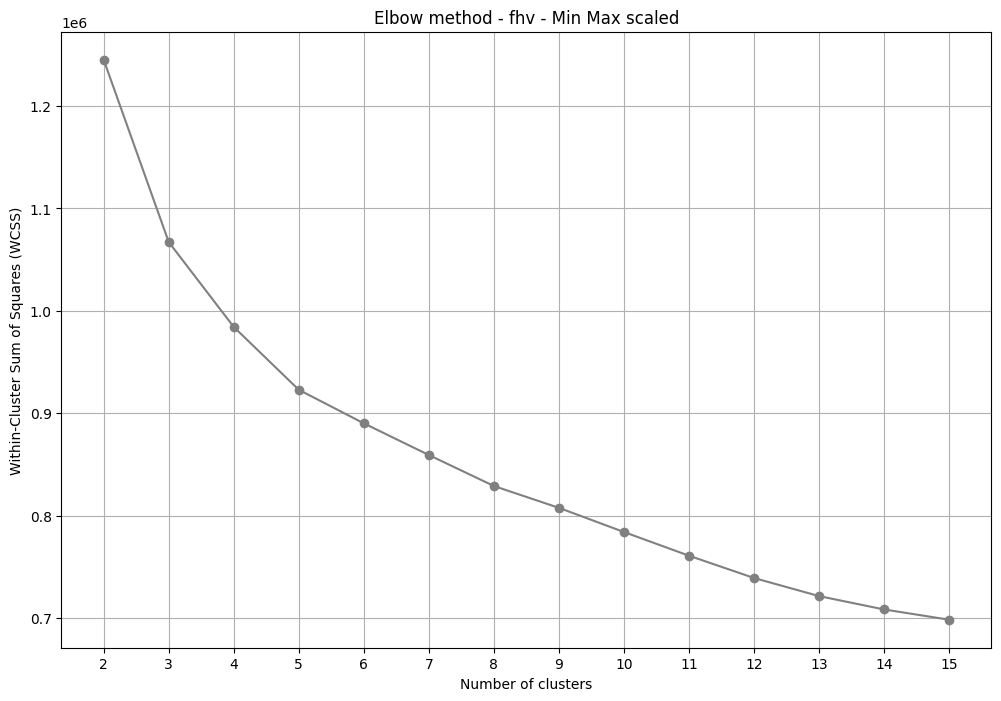

In [133]:
max_clusters = 16

wcss = []
for i in range(2, max_clusters):
    kmeans = KMeans(n_clusters=i, n_init="auto", random_state=42).fit(scaled_train_df)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(12, 8))
plt.plot(range(2, max_clusters), wcss, marker='o', linestyle='-', color='gray')
plt.title('Elbow method - fhv - Min Max scaled')
plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(range(2, max_clusters))
plt.grid(True)
plt.show()

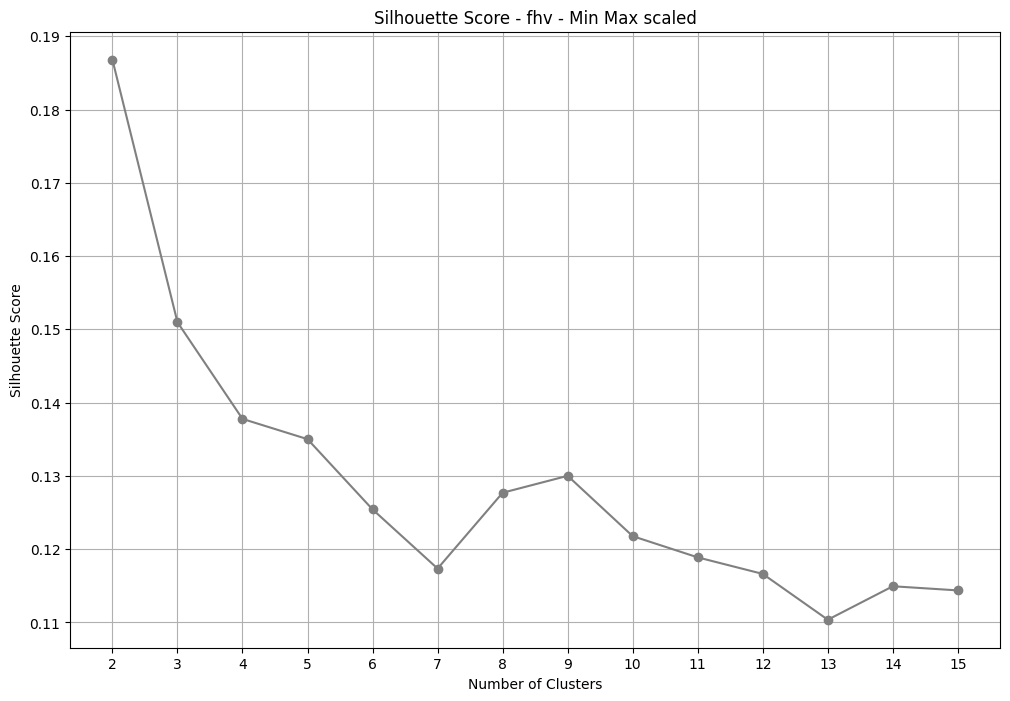

In [134]:
silhouette_scores = []

for i in range(2, max_clusters):
    kmeans = KMeans(n_clusters=i, n_init="auto", random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_smaller_train_df)
    silhouette_avg = silhouette_score(scaled_smaller_train_df, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(12, 8))
plt.plot(range(2, max_clusters), silhouette_scores, marker='o', linestyle='-', color='gray')
plt.title('Silhouette Score - fhv - Min Max scaled')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, max_clusters))
plt.grid(True)
plt.show()

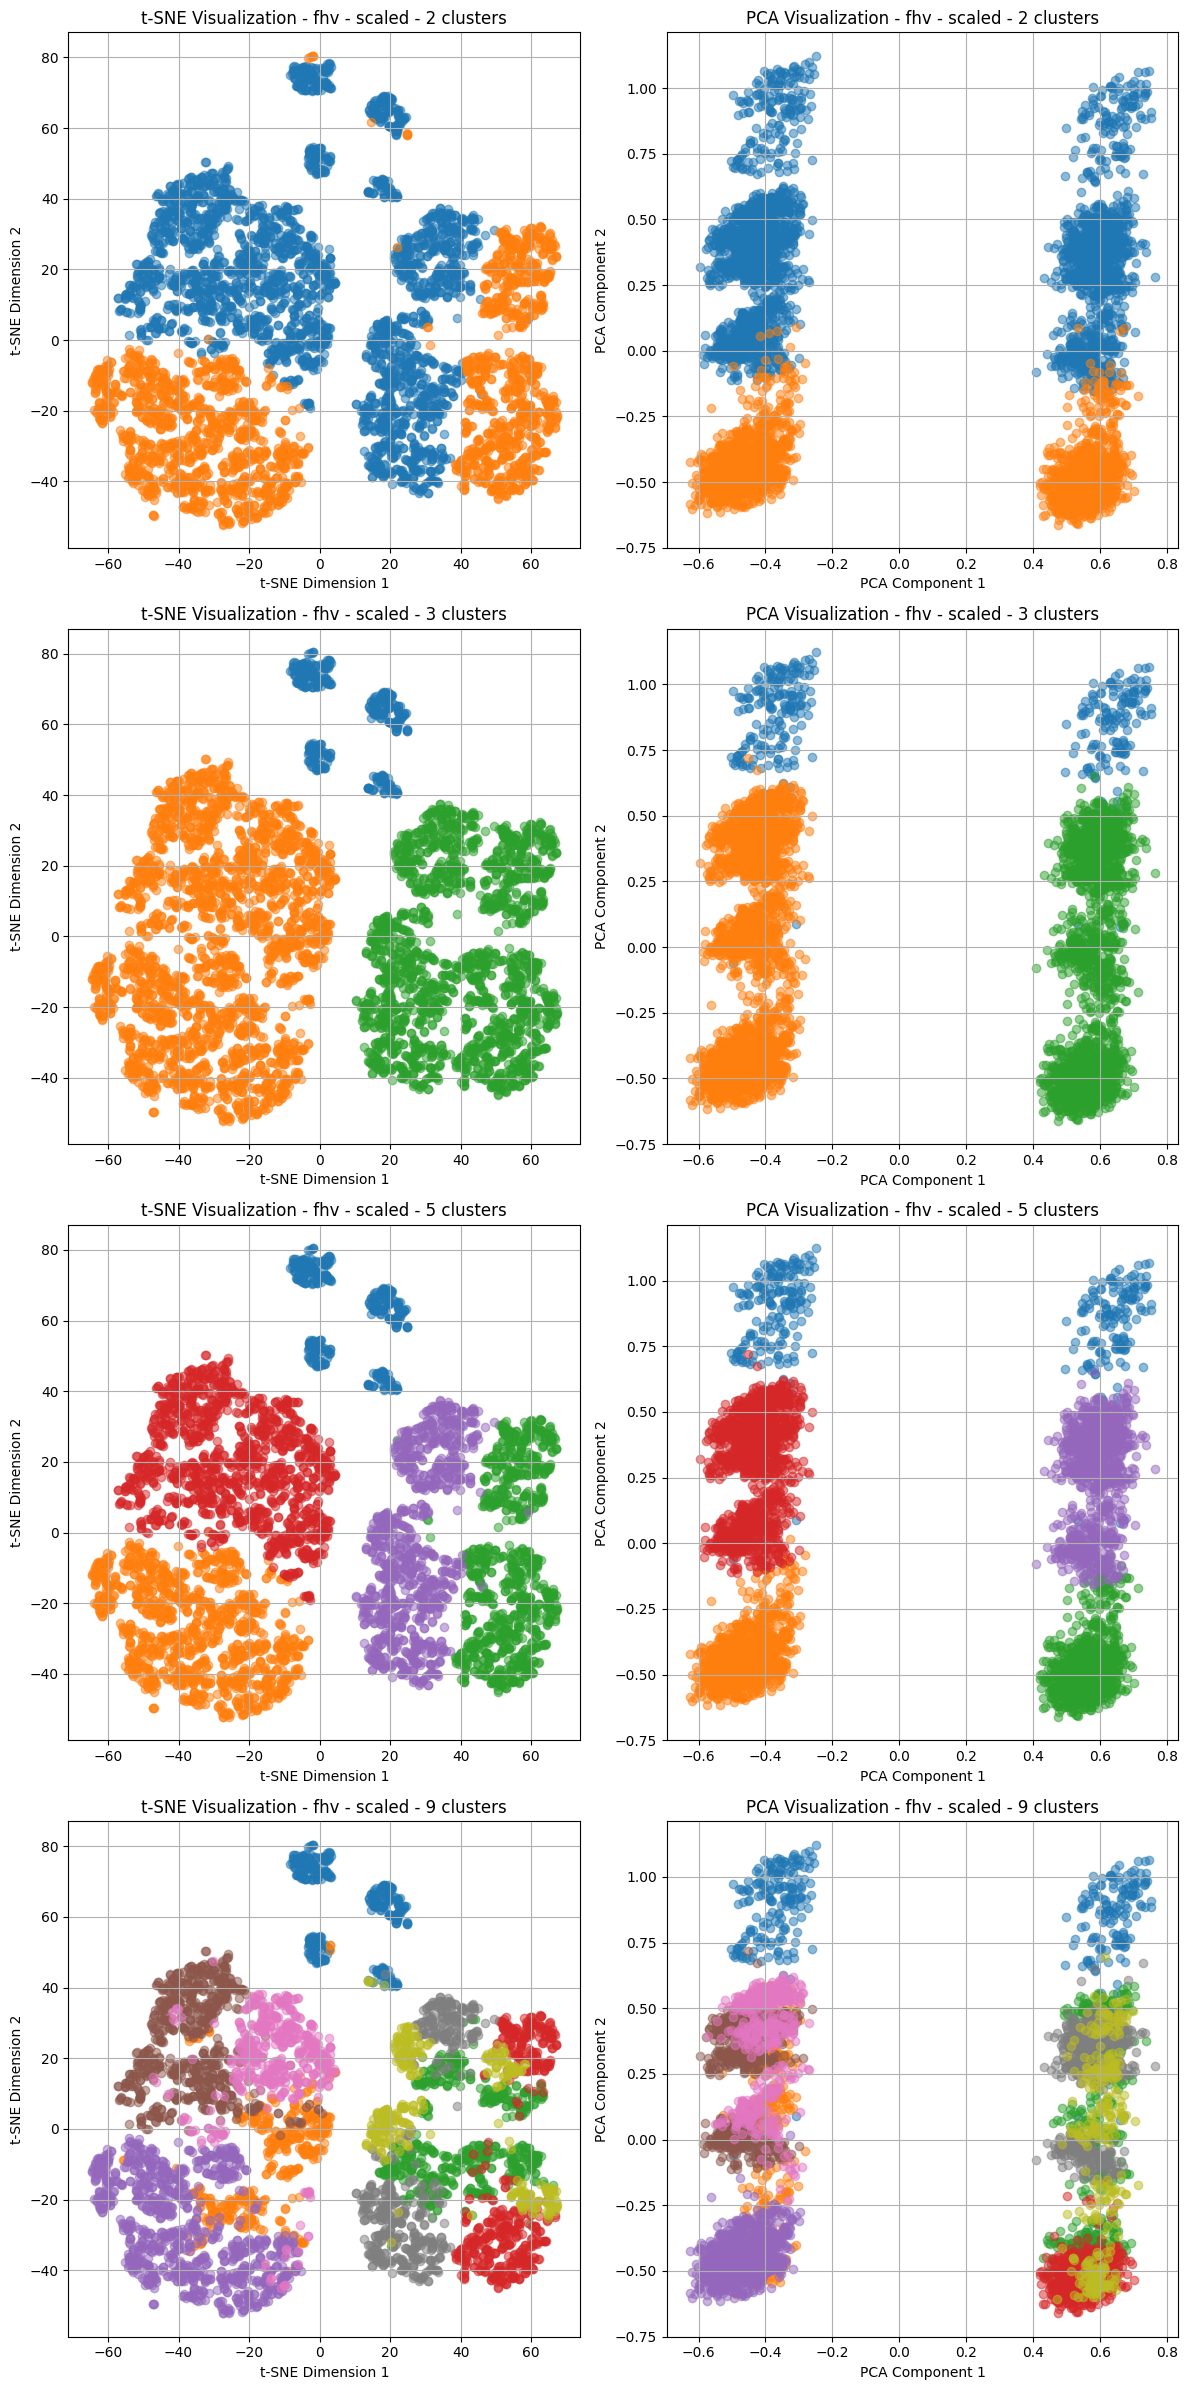

In [135]:
cluster_nums = [2, 3, 5, 9]

fig, axs = plt.subplots(len(cluster_nums), 2, figsize=(12, 6*len(cluster_nums)))

for j, clusters_num in enumerate(cluster_nums):
    kmeans = KMeans(n_clusters=clusters_num, n_init="auto", random_state=42).fit(scaled_train_df)
    cluster_labels = kmeans.predict(scaled_plot_train_df)

    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(scaled_plot_train_df)

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(scaled_plot_train_df)

    axs[j, 0].set_title(f't-SNE Visualization - fhv - scaled - {clusters_num} clusters')
    for i in range(clusters_num):
        axs[j, 0].scatter(X_tsne[cluster_labels == i, 0], X_tsne[cluster_labels == i, 1], label=f'Cluster {i}', alpha=0.5)
    axs[j, 0].set_xlabel('t-SNE Dimension 1')
    axs[j, 0].set_ylabel('t-SNE Dimension 2')
    # axs[j, 0].legend()
    axs[j, 0].grid(True)

    axs[j, 1].set_title(f'PCA Visualization - fhv - scaled - {clusters_num} clusters')
    for i in range(clusters_num):
        axs[j, 1].scatter(X_pca[cluster_labels == i, 0], X_pca[cluster_labels == i, 1], label=f'Cluster {i}', alpha=0.5)
    axs[j, 1].set_xlabel('PCA Component 1')
    axs[j, 1].set_ylabel('PCA Component 2')
    # axs[j, 1].legend()
    axs[j, 1].grid(True)

plt.tight_layout()
plt.show()

In [136]:
#TODO - try min max scaler also for yellow and green taxi
#TODO - try also other clustering methods (eg. Agglomerative Clustering, DBScan)
#TODO - check what is in outlier values (mainly in yellow and green taxi)